In [1]:
import re
import requests
import string
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from bertopic import BERTopic

In [2]:
# Load data

data = pd.read_csv("C:\PythonWorks\Research Paper\Final Data/whole_comment_data_en_re.csv", encoding = "utf-8")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37773 entries, 0 to 37772
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Comment       37772 non-null  object 
 1   Comment_date  37772 non-null  float64
 2   Likes         37772 non-null  float64
 3   class         37772 non-null  object 
 4   singer        37772 non-null  object 
 5   Comment_en    37772 non-null  object 
 6   en            37772 non-null  float64
dtypes: float64(3), object(4)
memory usage: 2.0+ MB


In [3]:
df.dropna(inplace = True)
df.isnull().sum()

Comment         0
Comment_date    0
Likes           0
class           0
singer          0
Comment_en      0
en              0
dtype: int64

# 1. Pre-processing the comment data
After scrapping all the comments data, I preprocess it to ensure the quality of the data. Especially, for the short-text data from social media, like YouTube, and Twitter it needs some specific steps for cleaning the data since those kinds of comments are written in informal ways that depend on the comment writers(Naseem et al., 2021). 
<br>So, I added some more steps for the data preprocessing not only classical preprocessing steps but for proposed by Naseem et al(2021). Below is the 11 steps for pre-processing short text data.

1. Translation(Optional)
2. Remove Unicodes, URLs, User-mentions and hashtags symbols 
3. Replacing Emojis
4. Correction of mispelled words
5. Expanding Contractions
6. Replacing Elongated words
7. Remove Punctuations
8. Lower Case
9. Word Segmentation 
10. Remove Stopwords 
11. Lemmatization 

## 1-1 Translation(Optional)
YouTube is one of the most popular video platforms in the world which is available in over 91 countries and supports 80 different languages. 
<br>Consequently, comments data have noise because of different languages and needed to be unified for better analytic results.
<br>In this thesis, I translated all the non-English data to English data using google translator API. 86.7%of the comments are written in English and remained 13.3% of comments are written in non-English language. 

In [5]:
from googletrans import Translator

translator = Translator()
#vr_comment = pd.read_csv("vr_comment_data.csv") ## Have to change
#df = vr_comment.copy()

#df["Comment_en"] = ""
#df["en"] = 1

comment_en = []
en = []
error = []

try:
    for i in range(0, len(df)):
        if translator.translate(df.iloc[i][0], dest="en").src == 'en':
            en.append(1)
            comment_en.append(df.iloc[i][0])
            time.sleep(1.5)
        else:
            eng_text = translator.translate(df.iloc[i][0], dest="en").text
            en.append(0)
            comment_en.append(eng_text)
            time.sleep(1.5)
except:    
    comment_en.append(df.iloc[i][0])
    en.append(0)
    error.append(i)
    print(i)
    pass

0


## 1-2 Remove Unicodes, URLs, User-mentions and hashtags symbols 
Some of Youtube comments included URLs user-mentions(@) and hashtag symbols(#) to write supplemental information, for example, recommending other videos, emphasizing the favorite part, etc. 
<br>That information is readable for humans, but it considered as noise for the purpose of text analysis In this thesis, text with is removed and hashtag and user-mentions text is modified to normal text.

In [6]:
def remove_mentions_hash(text):
    text = str(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URL
    text = re.sub(r'#', '', text) #Change hashtag text to normal text
    text = re.sub(r'^@', '', text) #Remove user-mention text
    return text

In [7]:
test = "@BBCNews lets take action! #fitness #health https://www.url.com"
remove_mentions_hash(test)

'BBCNews lets take action! fitness health '

## 1-3 Replacing Emoticons and Emojis 
Emoticons and Emojis(eg, “:)”, “:|”) give the information of the feelings, nuance of comment, so it important source of data. 
<br> In this project I used a python library called emot to replace them into valuable text data. .

In [10]:
EMOTICONS = {
    u":‑\)":"Happy or smiley",
    u":\)":"Happy or smiley",
    u":-\]":"Happy or smiley",
    u":\]":"Happy or smiley",
    u":-3":"Happy smiley",
    u":3":"Happy smiley",
    u":->":"Happy smiley",
    u":>":"Happy smiley",
    u"8-\)":"Happy smiley",
    u":o\)":"Happy smiley",
    u":-\}":"Happy smiley",
    u":\}":"Happy smiley",
    u":-\)":"Happy smiley",
    u":c\)":"Happy smiley",
    u":\^\)":"Happy smiley",
    u"=\]":"Happy smiley",
    u"=\)":"Happy smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [8]:
import emot 
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [11]:
text = "I've listen to this many to many time :)"
convert_emoticons(text)

"I've listen to this many to many time Happy_or_smiley"

## 1-4 Chat Slang Conversoi + Correction of mispelled words.
Incorrect spelling usually happens in comments data. 
<br>In addition to this, some writers intentionally use misspelled words by abbreviating them or by using slang. 
<br>When considering that those kinds of words are used in a specific context or among a particular group, it needs to be corrected to clear words. 
<br>I used the contextualSpellCheck library based on the BERT model in this thesis to correct incorrect spelling.
<br>https://github.com/R1j1t/contextualSpellCheck

In [10]:
#pip install contextualSpellCheck
#!pip install spacy
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
#!pip install spacy==2.3.5 --user

In [12]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [154]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [155]:
import contextualSpellCheck
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp = spacy.load("en_core_web_sm") 
## We require NER to identify if a token is a PERSON
## also require parser because we use `Token.sent` for context
nlp.pipe_names
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']
contextualSpellCheck.add_to_pipe(nlp)
nlp.pipe_names
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'contextual spellchecker']

['tok2vec',
 'tagger',
 'parser',
 'ner',
 'attribute_ruler',
 'lemmatizer',
 'contextual spellchecker']

In [156]:
def spell_check(text):
    text = chat_words_conversion(text)
    doc = nlp(text)
    if doc._.outcome_spellCheck:
        return doc._.outcome_spellCheck
    else:
        return(text)

In [16]:
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [17]:
import pkg_resources
from symspellpy import SymSpell

def spell_check_2(text):
    text = chat_words_conversion(text)
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2, ignore_non_words = True, transfer_casing=True)
    return(suggestions[0].term)

In [18]:
import pkg_resources
from symspellpy import SymSpell

def spell_check_3(text):
    text = chat_words_conversion(text)
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2, ignore_non_words = False, transfer_casing=True)
    return(suggestions[0].term)

In [19]:
df["Comment_en"][:10].apply(spell_check_2)

0    Alright I don't play footnote anymore but we h...
1    This was the best event of all time I have a l...
2    The deus are insane that they got this great v...
3    Amazing I miss this time I loved this season a...
4    I remember that this was the first event I saw...
5    Travis scott go in soon hard on this right her...
6    Marshmallow gets a stage Travis Scott gets spa...
7    Even after 2 years in 2022 this is still the b...
8                                       Such nostalgia
9                                   I loved that event
Name: Comment_en, dtype: object

In [257]:
origin = df["Comment_en"][:70]
context = origin.apply(spell_check)
sym_1 = origin.apply(spell_check_2)
sym_2 = origin.apply(spell_check_3)
check_spell = pd.DataFrame({"Original" : origin, "Context": context, "SymSpell_1": sym_1,  "SymSpell_2": sym_2})
check_spell.to_csv("check_spll.csv", index = False, encoding = "utf-8-sig")

In [155]:
print('\n'.join([x for x in df["Comment_en"][10:21]]))

Alright, I don’t play fortnite anymore but we have to admit this is one of the best events in gaming history…
This was the best event of all time ! 
I have a lot of memories
The devs are insane that they got this great visuals on live game !! Big W!
Amazing, I miss this time, I loved this season and the map, it was the time I played this game the most.
I remember that this was the first event I saw, what memories
Travis scott go in sooo hard on this right here, straight up BANGER! He aint like all them artists who just be goin HAM ON THE GRAM by usin dat ig rocket   to get followers up on the gram like them Island Boys dun did
Marshmello: gets a stage
Travis Scott: gets space
Galactus: gets the entire multiverse
Even after 2 years in 2022 this is still the best event no question
Such nostalgia…
I loved that event


## 1-5 Expanding Contractions 
Expanding contractions allows efficient lemmatization in the later step. 
<br>For example, when the word in written can’t, it will be lemmatized to can and t. 
<br>Through this step, words will be changed to can not and this can lessen the noise of the text data.

## 1-6 Replacing Elongated words 
When people write comments, they sometimes write them in a longer way than their original words to express their sentiments. 
<br>For example, there are some words “yeeees”, “yeeeeee”, “woooow” in the dataset, and could be changed to “yes”, “ye”, and “wow”. 
<br>It is suggested when the same characters are consecutively written more than three times, they can be considered elongated words and replaced with one character(Kiritchenko et al., 2014). 
<br>https://github.com/cbaziotis/ekphrasis

In [203]:
#!pip install ekphrasis

     -------------------------------------- 83.8/83.8 kB 102.3 kB/s eta 0:00:00
     -------------------------------------- 53.1/53.1 kB 389.6 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [205]:
import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
text_processor = TextPreProcessor(
    # terms that will be annotated
    annotate={"elongated", 'expan_elongat'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 

    unpack_hashtags=False,  # perform word segmentation on hashtags
    unpack_contractions = True,  # Unpack contractions (can't -> can not)
    spell_correct_elong = False,  # spell correction for elongated words,
    spell_correction = True,
    remove_tags = True,
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    #tokenizer=SocialTokenizer(lowercase=False).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
)

Reading twitter - 1grams ...


In [206]:
def expan_elongat(text):
    text = text
    return text_processor.pre_process_doc(text)

In [207]:
text = "Mannn its sad how good this concert is but can't never come back same with the skin "

expan_elongat(text)

'Man its sad how good this concert is but can not never come back same with the skin'

## 1-7 Remove Punctuations 
Removing punctuation is one of the classical pre-processing steps that eliminate line change for the comment data. 
<br>For humans, line change makes it simpler to read, but for the machine, it is just a white space that doesn’t have any meaning.

In [126]:
punct_list = string.punctuation
def remove_punctuation(text):
    text = re.sub('\s+', ' ', text)
    return text.translate(str.maketrans('', '', punct_list))

In [127]:
print(" Original:",df["Comment_en"][707],"\n\n",
      "Removed:",remove_punctuation(df["Comment_en"][707]))

 Original: Epic games: how big you want to be?
Travis Scott: yes

[Edit]Thanks for the likes guys 

 Removed: Epic games how big you want to be Travis Scott yes EditThanks for the likes guys


In [162]:
df["Comment_en"][:10].apply(remove_punctuation)

0    Alright I don’t play fortnite anymore but we h...
1    This was the best event of all time  I have a ...
2    The devs are insane that they got this great v...
3    Amazing I miss this time I loved this season a...
4    I remember that this was the first event I saw...
5    Travis scott go in sooo hard on this right her...
6    Marshmello gets a stage Travis Scott gets spac...
7    Even after 2 years in 2022 this is still the b...
8                                      Such nostalgia…
9                                   I loved that event
Name: Comment_en, dtype: object

## 1-8 Lower Case 
Removing punctuation is one of the classical pre-processing steps that eliminate line change for the comment data. 
<br>For humans, line change makes it simpler to read, but for the machine, it is just a white space that doesn’t have any meaning.

In [58]:
def lower_text(text):
    text = text.lower()
    return text

In [60]:
text = "HELLO THIS IS WORD"
lower_text(text)

'hello this is word'

In [166]:
df["Comment_en"][:10].apply(lower_text)

0    alright, i don’t play fortnite anymore but we ...
1    this was the best event of all time ! \ni have...
2    the devs are insane that they got this great v...
3    amazing, i miss this time, i loved this season...
4    i remember that this was the first event i saw...
5    travis scott go in sooo hard on this right her...
6    marshmello: gets a stage\ntravis scott: gets s...
7    even after 2 years in 2022 this is still the b...
8                                      such nostalgia…
9                                   i loved that event
Name: Comment_en, dtype: object

## 1-9 Word Segmentation
Users sometimes write the comments with hashtag and in informal ways, especially concatenate all the words without spacing. 
<br>It is because to keep the whole sentence belonging to the hashtag or sometimes to avoid length limitation. 
<br>In this thesis, I remove the hashtag from prior step and then segment the sentence by word utilizing ekphrasis library that is specialized to social media text data.

In [179]:
#!pip install wordsegment

     ---------------------------------------- 4.8/4.8 MB 1.8 MB/s eta 0:00:00


In [210]:
from wordsegment import load, segment
load()
def word_seg(text):
    text = ' '.join(segment(text))
    return text

In [178]:
text = "Ariana is so beautiful and talented. She literally has a voice like an angel !. Arianagrande Godisawoman"
word_seg(text)

'ariana is so beautiful and talented she literally has a voice like an angel ariana grande god is a woman'

In [167]:
df["Comment_en"][:10].apply(word_seg)

0    alright i dont play fort nite anymore but we h...
1    this was the best event of all time i have a l...
2    the devs are insane that they got this great v...
3    amazing i miss this time i loved this season a...
4    i remember that this was the first event i saw...
5    travis scott go in sooo hard on this right her...
6    marsh mello gets a stage travis scott gets spa...
7    even after 2yearsin2022 this is still the best...
8                                       such nostalgia
9                                   i loved that event
Name: Comment_en, dtype: object

In [ ]:
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell_seg = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell_seg.load_dictionary(dictionary_path, term_index=0, count_index=1)

def word_segment(text):
    text = text
    result = sym_spell.word_segmentation(text)
    return(result.corrected_string)

## 1-10 Remove Number 
Numbers in comments are usually deleted when conducting text classification. 
<br>Especially numbers from YouTube comments are to point out the most favorite part of the Video, so it doesn’t include any information. 
<br>However, in this project, investigating people’s thinking over time is essential, so year information would be an important cue for understanding it. 
<br>Therefore, numbers without expressing the year would be removed from this project.

In [122]:
def remove_num(text):
    text = re.sub(r'([0-9]+)', '', text)
    return text

In [123]:
text = "This was the only time I was proud to say I played fortnite anytime after 2019, and I wathced it for 10 times gr8"
remove_num(text)

'This was the only time I was proud to say I played fortnite anytime after , and I wathced it for  times gr'

In [168]:
df["Comment_en"][:10].apply(remove_num)

0    Alright, I don’t play fortnite anymore but we ...
1    This was the best event of all time ! \nI have...
2    The devs are insane that they got this great v...
3    Amazing, I miss this time, I loved this season...
4    I remember that this was the first event I saw...
5    Travis scott go in sooo hard on this right her...
6    Marshmello: gets a stage\nTravis Scott: gets s...
7    Even after  years in  this is still the best e...
8                                      Such nostalgia…
9                                   I loved that event
Name: Comment_en, dtype: object

## 1-11 Remove Stopwords
Remove the meaningless words with the stop words from the Natural Language Toolkit (NLTK) python library(eg, “the”, “a”, “an”)
<br>and the name of the singer such as “travis” and “scott” to catch more informative words and faster processing time.

In [158]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', "travis", "scott", "ari", "ariana", "grande", "ariana grande", 
                  "juciy", "juice", "marshmello"]
stop_words = stop_words + more_stopwords

In [159]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [167]:
text = "Let’s go Travis go let’s go I’m the biggest fan let’s go check on y’all keep saying that I"
text = remove_stopwords(text.lower())
text

'let’s go go let’s go i’m biggest fan let’s go check y’all keep saying'

In [169]:
df["Comment_en"][:10].apply(remove_stopwords)

0    Alright, I don’t play fortnite anymore admit o...
1              This best event time ! \nI lot memories
2    The devs insane got great visuals live game !!...
3    Amazing, I miss time, I loved season map, time...
4               I remember first event I saw, memories
5    Travis go sooo hard right here, straight BANGE...
6    Marshmello: gets stage\nTravis Scott: gets spa...
7          Even 2 years 2022 still best event question
8                                      Such nostalgia…
9                                        I loved event
Name: Comment_en, dtype: object

## 1-12 Lemmatization 
Remove the meaningless words with the stop words from the Natural Language Toolkit (NLTK) python library(eg, “the”, “a”, “an”)
<br>and the name of the singer such as “travis” and “scott” to catch more informative words and faster processing time.

In [132]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kjkoo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [173]:
text = "I survived that concert"
lemmatize_words(text)

'I survive that concert'

In [172]:
df["Comment_en"][:10].apply(lemmatize_words)

0    Alright, I don’t play fortnite anymore but we ...
1    This be the best event of all time ! I have a ...
2    The devs be insane that they get this great vi...
3    Amazing, I miss this time, I love this season ...
4    I remember that this be the first event I saw,...
5    Travis scott go in sooo hard on this right her...
6    Marshmello: get a stage Travis Scott: get spac...
7    Even after 2 year in 2022 this be still the be...
8                                      Such nostalgia…
9                                    I love that event
Name: Comment_en, dtype: object

## 1-13 Text Preprocessor for Shrot text from Social Media
This is the combinde code for preprocessing 

In [4]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""
EMOTICONS = {
    u":‑\)":"Happy or smiley",
    u":\)":"Happy or smiley",
    u":-\]":"Happy or smiley",
    u":\]":"Happy or smiley",
    u":-3":"Happy smiley",
    u":3":"Happy smiley",
    u":->":"Happy smiley",
    u":>":"Happy smiley",
    u"8-\)":"Happy smiley",
    u":o\)":"Happy smiley",
    u":-\}":"Happy smiley",
    u":\}":"Happy smiley",
    u":-\)":"Happy smiley",
    u":c\)":"Happy smiley",
    u":\^\)":"Happy smiley",
    u"=\]":"Happy smiley",
    u"=\)":"Happy smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [13]:
# Preparing for the tool
##1. Remove url, user menthions
def remove_mentions_hash(text):
    text = str(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URL
    text = re.sub(r'#', '', text) #Change hashtag text to normal text
    text = re.sub(r'^@', '', text) #Remove user-mention text
    return text

#2. Change emoticons to words
import emot 
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

#3. Correction misspelled v1
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

import contextualSpellCheck
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
nlp = spacy.load("en_core_web_sm") 
nlp.pipe_names
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']
contextualSpellCheck.add_to_pipe(nlp)
nlp.pipe_names
['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer', 'contextual spellchecker']

def spell_check_1(text):
    text = chat_words_conversion(text)
    doc = nlp(text)
    if doc._.outcome_spellCheck:
        return doc._.outcome_spellCheck
    else:
        return(text)
# 3-2    
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

def spell_check_2(text):
    text = chat_words_conversion(text)
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2, ignore_non_words = True, transfer_casing=True)
    return(suggestions[0].term)

# 3-3
def spell_check_3(text):
    text = chat_words_conversion(text)
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2, ignore_non_words = False, transfer_casing=True)
    return(suggestions[0].term)
    
#4,5 . Expand contractino and change elongate
import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
text_processor = TextPreProcessor(
    # terms that will be annotated
    annotate={"elongated", 'expan_elongat'},
    fix_html=True, 
    corrector="twitter", 
    unpack_hashtags=False, 
    unpack_contractions = True,
    spell_correct_elong = False,
    spell_correction = True,
    remove_tags = True,
)
def expan_elongat(text):
    text = text
    return text_processor.pre_process_doc(text)

#6. Remove Puncutation
punct_list = string.punctuation
def remove_punctuation(text):
    text = re.sub('\s+', ' ', text)
    return text.translate(str.maketrans('', '', punct_list))

#7. Lower Case
def lower_text(text):
    text = text.lower()
    return text

#8. Word Segmentation
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell_seg = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell_seg.load_dictionary(dictionary_path, term_index=0, count_index=1)

def word_segment(text):
    text = text
    result = sym_spell.word_segmentation(text)
    return(result.corrected_string)

#9. Remove Number
def remove_num(text):
    text = re.sub(r'([0-9]+)', '', text)
    return text

#10. Remove Stop Words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', "travis", "scott", "ari", "ariana", "grande", "ariana grande", 
                  "juciy", "juice", "marshmello"]
stop_words = stop_words + more_stopwords
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

#11. Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

Reading twitter - 1grams ...


In [14]:
# Make multiple processor for checking the optimal the spell_check tool

In [15]:
def shorttext_preporcessor_v1(text):
    try:
        text = remove_mentions_hash(text)
        text = convert_emoticons(text)
        text = spell_check_1(text)
        text = expan_elongat(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = word_segment(text)
        text = remove_num(text)
        text = remove_stopwords(text)
        text = lemmatize_words(text)
    except:
        return "error"
    return text

In [16]:
def shorttext_preporcessor_v2(text):
    try:
        text = remove_mentions_hash(text)
        text = convert_emoticons(text)
        text = spell_check_2(text)
        text = expan_elongat(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = word_segment(text)
        text = remove_num(text)
        text = remove_stopwords(text)
        text = lemmatize_words(text)
    except:
        return "error"
    return text

In [17]:
def shorttext_preporcessor_v3(text):
    try:
        text = remove_mentions_hash(text)
        text = convert_emoticons(text)
        text = spell_check_3(text)
        text = expan_elongat(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = word_segment(text)
        text = remove_num(text)
        text = remove_stopwords(text)
        text = lemmatize_words(text)
    except:
        return "error"
    return text

In [18]:
def shorttext_preporcessor_v4(text): # No Spell Check
    try:
        text = remove_mentions_hash(text)
        text = convert_emoticons(text)
        text = expan_elongat(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = word_segment(text)
        text = remove_num(text)
        text = remove_stopwords(text)
        text = lemmatize_words(text)
    except:
        return "error"
    return text

In [13]:
test = df["Comment_en"][0:10]
test = test.apply(shorttext_preporcessor_v4)
test

0    alright play footnote anymore admit one best e...
1                           best event time lot memory
2        desire insane get great visuals live game big
3       amaze miss time love season map time play game
4                      remember first event saw memory
5    go hard right straight banger int like artist ...
6    marshmallow get stage get space galactic get e...
7                  even year still best event question
8                                            nostalgia
9                                           love event
Name: Comment_en, dtype: object

In [14]:
df["comment_clean_1"] = df['Comment_en'].apply(shorttext_preporcessor_v1)
df["comment_clean_1"].head()

0    alright play football anymore admit one best e...
1                           best event time lot memory
2              guy insane get great idea live game big
3       amaze miss time love season map time play game
4                      remember first event saw memory
Name: comment_clean_1, dtype: object

In [15]:
df["comment_clean_2"] = df['Comment_en'].apply(shorttext_preporcessor_v2)
df["comment_clean_2"].head()

0    alright play footnote anymore admit one best e...
1                           best event time lot memory
2          deus insane get great visuals live game big
3       amaze miss time love season map time play game
4                      remember first event saw memory
Name: comment_clean_2, dtype: object

In [16]:
df["comment_clean_3"] = df['Comment_en'].apply(shorttext_preporcessor_v3)
df["comment_clean_3"].head()

0    alright play footnote anymore admit one best e...
1                           best event time lot memory
2          deus insane get great visuals live game big
3       amaze miss time love season map time play game
4                      remember first event saw memory
Name: comment_clean_3, dtype: object

In [17]:
df["comment_clean_4"] = df['Comment_en'].apply(shorttext_preporcessor_v4)
df["comment_clean_4"].head()

0    alright play footnote anymore admit one best e...
1                           best event time lot memory
2        desire insane get great visuals live game big
3       amaze miss time love season map time play game
4                      remember first event saw memory
Name: comment_clean_4, dtype: object

In [18]:
df.to_csv("cleaned_comment_data.csv", index = False, encoding = 'utf-8-sig')

# 2. Descriptive Resluts of the data (Distributino analysis, Utilize Word Embedding model to understand how main data is organized)
- 2.1 Simple distribtuion analysis of data
- 2.2 Result with simple processing and stemmiaztion
- 2.3 Result with the CountVectorizer
- 2.4 Result with the TF-IDF model(Main model)

## 2.1 Analzye the distribution of the data

In [20]:
# Load Data
data = pd.read_csv("cleaned_comment_data.csv", encoding = 'utf-8-sig')
df = data.copy()
df.head()

,Comment,Comment_date,Likes,class,singer,Comment_en,en,comment_clean_1,comment_clean_2,comment_clean_3,comment_clean_4
0,"Alright, I don’t play fortnite anymore but we ...",2021.0,1400.0,vr_concert,travis_scott,"Alright, I don’t play fortnite anymore but we ...",1.0,alright play football anymore admit one best e...,alright play footnote anymore admit one best e...,alright play footnote anymore admit one best e...,alright play footnote anymore admit one best e...
1,This was the best event of all time ! \nI have...,2022.0,87.0,vr_concert,travis_scott,This was the best event of all time ! \nI have...,1.0,best event time lot memory,best event time lot memory,best event time lot memory,best event time lot memory
2,The devs are insane that they got this great v...,2022.0,57.0,vr_concert,travis_scott,The devs are insane that they got this great v...,1.0,guy insane get great idea live game big,deus insane get great visuals live game big,deus insane get great visuals live game big,desire insane get great visuals live game big
3,"Amazing, I miss this time, I loved this season...",2022.0,3.0,vr_concert,travis_scott,"Amazing, I miss this time, I loved this season...",1.0,amaze miss time love season map time play game,amaze miss time love season map time play game,amaze miss time love season map time play game,amaze miss time love season map time play game
4,Me acuerdo que este fue el primer evento que v...,2022.0,60.0,vr_concert,travis_scott,I remember that this was the first event I saw...,0.0,remember first event saw memory,remember first event saw memory,remember first event saw memory,remember first event saw memory


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37772 entries, 0 to 37771
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Comment          37772 non-null  object 
 1   Comment_date     37772 non-null  float64
 2   Likes            37772 non-null  float64
 3   class            37772 non-null  object 
 4   singer           37772 non-null  object 
 5   Comment_en       37772 non-null  object 
 6   en               37772 non-null  float64
 7   comment_clean_1  36225 non-null  object 
 8   comment_clean_2  36786 non-null  object 
 9   comment_clean_3  36796 non-null  object 
 10  comment_clean_4  36545 non-null  object 
dtypes: float64(3), object(8)
memory usage: 3.2+ MB


In [21]:
# Comments distribution by year

len_2019 = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["Comment_date"] == 2019)])
len_2020 = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["Comment_date"] == 2020)])
len_2021 = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["Comment_date"] == 2021)])
len_2022 = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["Comment_date"] == 2022)])
len_2019 + len_2020 + len_2021 + len_2022 == len(df["comment_clean_2"][df["class"] == "vr_concert"])
num_comments = [len_2019, len_2020, len_2021, len_2022]
year_data = pd.DataFrame({"count_year": num_comments})
year_data

,count_year
0,241
1,1482
2,2575
3,6000


In [6]:
year_stat = pd.DataFrame(year_data["count_year"].describe())
year_stat

,count_year
count,4.000000
mean,2574.500000
std,2474.727527
min,241.000000
25%,1171.750000
50%,2028.500000
75%,3431.250000
max,6000.000000


In [22]:
# Comments distribution by singer

len_marsh = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["singer"] == "marshmello")])
len_ariana = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["singer"] == "ariana_grande")])
len_traviss = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["singer"] == "travis_scott")])
len_trimix = len(df["comment_clean_2"][(df["class"] == "vr_concert") & (df["singer"] == "trimix")])
len_marsh + len_ariana + len_traviss + len_trimix == len(df["comment_clean_2"][df["class"] == "vr_concert"])
sing_num_comments = [len_marsh, len_ariana, len_traviss, len_trimix]
singer_data = pd.DataFrame({"count_singer": sing_num_comments})
singer_data

,count_singer
0,1360
1,2528
2,5097
3,1313


In [8]:
singer_stat = pd.DataFrame(singer_data.describe())
singer_stat

,count_singer
count,4.000000
mean,2574.500000
std,1773.091556
min,1313.000000
25%,1348.250000
50%,1944.000000
75%,3170.250000
max,5097.000000


In [9]:
# Comments distribution by singer

len_vr = len(df["comment_clean_2"][(df["class"] == "vr_concert")])
len_pre = len(df["comment_clean_2"][(df["class"] == "general_concert_pre_covid")])
len_after = len(df["comment_clean_2"][(df["class"] == "general_concert_after_covid")])
clas_num_comments = [len_vr, len_pre, len_after]
class_data = pd.DataFrame({"count_class": clas_num_comments})
class_data

,count_class
0,10298
1,13569
2,13905


In [10]:
class_stat = pd.DataFrame(class_data.describe())
class_stat

,count_class
count,3.000000
mean,12590.666667
std,1992.602402
min,10298.000000
25%,11933.500000
50%,13569.000000
75%,13737.000000
max,13905.000000


In [11]:
data_stat = pd.concat([year_stat,singer_stat, class_stat], axis = 1).round(2)
data_stat.to_csv("data_stat.csv")
data_stat

,count_year,count_singer,count_class
count,4.00,4.00,3.00
mean,2574.50,2574.50,12590.67
std,2474.73,1773.09,1992.60
min,241.00,1313.00,10298.00
25%,1171.75,1348.25,11933.50
50%,2028.50,1944.00,13569.00
75%,3431.25,3170.25,13737.00
max,6000.00,5097.00,13905.00


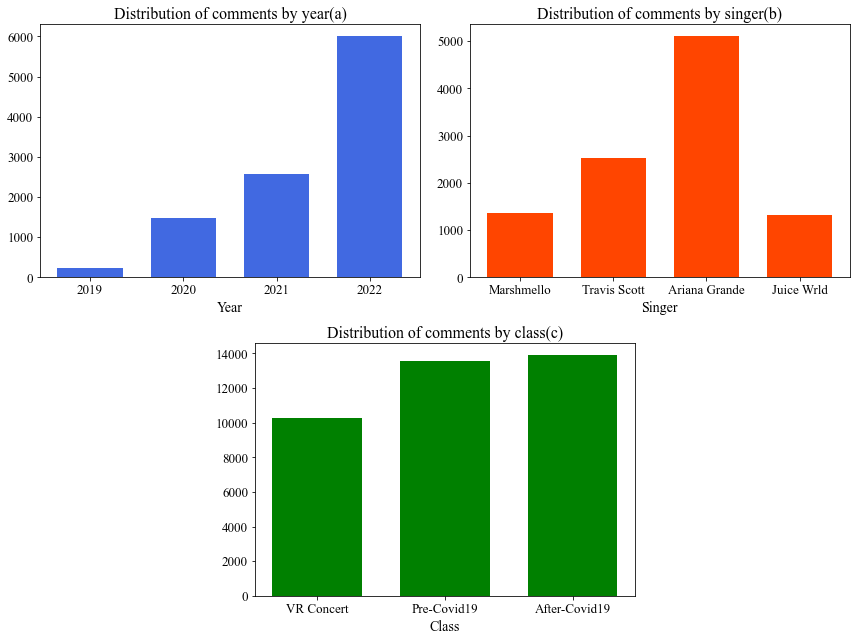

In [40]:
fig = plt.figure(constrained_layout = True, figsize = (12, 9))
grid = plt.GridSpec(2, 4)

#ax = axis.flatten()
ax1 = fig.add_subplot(grid[0:2])

objects = ("2019", "2020", "2021", "2022")
y_pos = np.arange(len(objects))
num_comments = [len_2019, len_2020, len_2021, len_2022]
plt.bar(y_pos, num_comments, alpha = 1, color = 'royalblue', width = 0.7)
plt.xticks(y_pos, objects, size = 13, rotation = 0)
plt.xlabel('Year', size = 14)
plt.yticks(size = 13)
ax1.set_title('Distribution of comments by year(a)', fontsize = 16)


ax2 = fig.add_subplot(grid[2:4])

objects = ("Marshmello", "Travis Scott", "Ariana Grande", "Juice Wrld")
y_pos = np.arange(len(objects))
num_comments_singer = [len_marsh, len_ariana, len_traviss, len_trimix]
plt.bar(y_pos, num_comments_singer, color = "orangered", align='center', alpha = 1, width = 0.7)
plt.xticks(y_pos, objects, size = 13, rotation = 0)
plt.xlabel('Singer', size = 14)
plt.yticks(size = 13)
ax2.set_title('Distribution of comments by singer(b)', fontsize = 16)

ax3 = fig.add_subplot(grid[5:7])

objects = ("VR Concert", "Pre-Covid19", "After-Covid19")
y_pos = np.arange(len(objects))
num_comments_class = [len_vr, len_pre, len_after]
plt.bar(y_pos, num_comments_class, color = "green", align='center', alpha = 1, width = 0.7)
plt.xticks(y_pos, objects, size = 13, rotation = 0)
plt.xlabel('Class', size = 14)
plt.yticks(size = 13)
ax3.set_title('Distribution of comments by class(c)', fontsize = 16)



#plt.suptitle("TF-IDF score comparsion bettwen VR concert videos and general concert videos", fontsize = 17)
plt.tight_layout()
#plt.show()
plt.savefig('Distributino of Comment.png', bbox_inches='tight')

## 2.2 Result with simple processing and stemmiaztion
Through this process, I will manually check out some odd words that generated throguh misspelled check, was not in stop words or not well pre-processed from prior step.<br>
Then do the simple preprocessing to delete those words and do the analysisfrom nltk.corpus import stopwords

In [28]:
df_vr_1 = df['comment_clean_1'][df['comment_clean_1'].notnull()][df["class"] == "vr_concert"].reset_index(drop = True)
df_vr_1= df_vr_1[df_vr_1 != '']
df_vr_1= df_vr_1[df_vr_1 != 'error']
df_vr_1.reset_index(drop = True, inplace = True)
df_vr_2 = df['comment_clean_2'][df['comment_clean_2'].notnull()][df["class"] == "vr_concert"].reset_index(drop = True)
df_vr_2 = df_vr_2[df_vr_2 != '']
df_vr_2= df_vr_2[df_vr_2 != 'error']
df_vr_2.reset_index(drop = True, inplace = True)
df_vr_3 = df['comment_clean_3'][df['comment_clean_3'].notnull()][df["class"] == "vr_concert"].reset_index(drop = True)
df_vr_3= df_vr_3[df_vr_3 != '']
df_vr_3= df_vr_3[df_vr_3 != 'error']
df_vr_3.reset_index(drop = True, inplace = True)
df_vr_4 = df['comment_clean_4'][df['comment_clean_4'].notnull()][df["class"] == "vr_concert"].reset_index(drop = True)
df_vr_4= df_vr_4[df_vr_4 != '']
df_vr_4= df_vr_4[df_vr_4 != 'error']
df_vr_4.reset_index(drop = True, inplace = True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37772 entries, 0 to 37771
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Comment          37772 non-null  object 
 1   Comment_date     37772 non-null  float64
 2   Likes            37772 non-null  float64
 3   class            37772 non-null  object 
 4   singer           37772 non-null  object 
 5   Comment_en       37772 non-null  object 
 6   en               37772 non-null  float64
 7   comment_clean_1  36225 non-null  object 
 8   comment_clean_2  36786 non-null  object 
 9   comment_clean_3  36796 non-null  object 
 10  comment_clean_4  36545 non-null  object 
dtypes: float64(3), object(8)
memory usage: 3.2+ MB


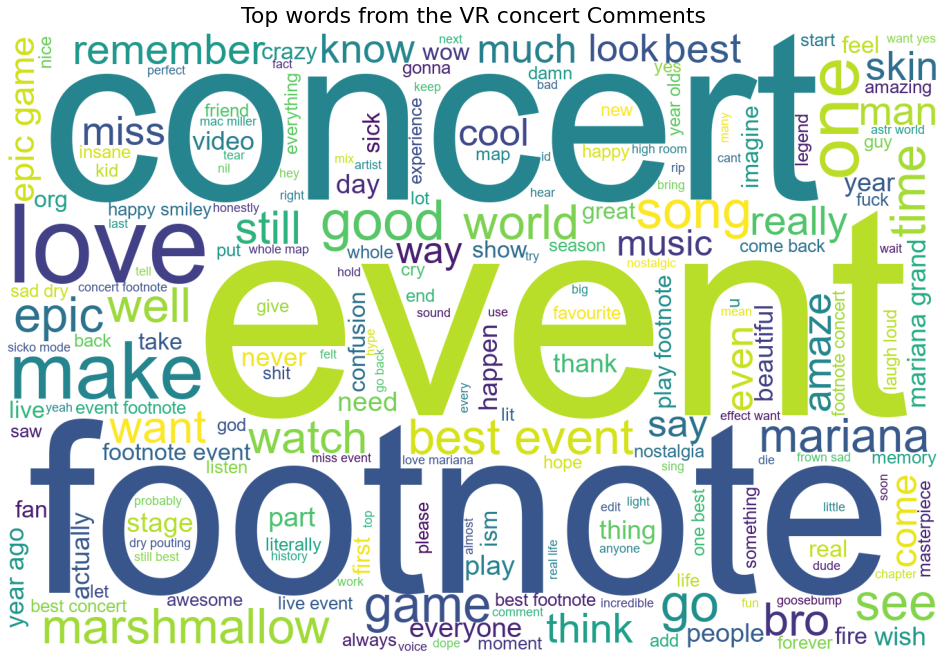

In [38]:
# Make the Worldcoud with the simple processing and stemmiaztion
wc = WordCloud(font_path='arial',
               background_color='white', 
                max_words=200,
                width=1350, height=900,
              stopwords = STOPWORDS)
wc.generate(' '.join(text for text in df_vr_2))
plt.figure(figsize=(13.5,9))
plt.title('Top words from the VR concert Comments', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
#plt.savefig('wordcloud.png', bbox_inches='tight')

I will delete words 'u', 'im', 'c', "travis", "scott", "ari", "ariana", "grande", "ariana grande", 
                  "juciy", "juice", "marshmello", "fort", "nite", "marsh", "mello", "mac", "miller", "scott", 
                  "football", "footnote", "mariana", "marianas", "marshmallow", "marshmellow", "grand", "epic"

In [31]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', "travis", "scott", "ari", "ariana", "grande", "ariana grande", 
                  "juciy", "juice", "marshmello", "fort", "nite", "marsh", "mello", "mac", "miller", "scott", 
                  "football", "footnote", "mariana", "marianas", "marshmallow", "marshmellow", "grand", "epic"]
man_stop_words = stop_words + more_stopwords

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [32]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in man_stop_words)
    return text

def after_process(text):
    text = remove_stopwords(text)
    text = text.strip()
    text = lemmatize_words(text)
    return text

In [33]:
#df_vr_1 = df_vr_1.apply(after_process)
df_vr_wb_2 = df_vr_2.apply(after_process) ## This is the optimal data for the research
#df_vr_3 = df_vr_3.apply(after_process)
#df_vr_4 = df_vr_4.apply(after_process)

## 2.3 Result with the CountVectorizer

In [44]:
# Fit the comment

vect = CountVectorizer(stop_words=man_stop_words, ngram_range=(1, 1))
vect.fit(df_vr_wb_2)

CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [59]:
# Top 20 words from fitted data

coment_vec = vect.transform(df_vr_wb_2)
coment_words = coment_vec.sum(axis = 0)
coment_words_freq = [(word, coment_words[0, idx]) for word, idx in vect.vocabulary_.items()]
comment_tf = pd.DataFrame(list(sorted(coment_words_freq, key = lambda x: x[1], reverse=True)), columns = ['Terms',"Count_vectorizer_count"])
comment_tf = comment_tf.set_index("Terms")
comment_tf['Count_vectorizer_count'].sort_values(ascending = False)

Terms
event           1979
concert         1187
best             972
like             856
love             780
                ... 
hr                 1
transit            1
headquarters       1
whine              1
pizzeria           1
Name: Count_vectorizer_count, Length: 4140, dtype: int64

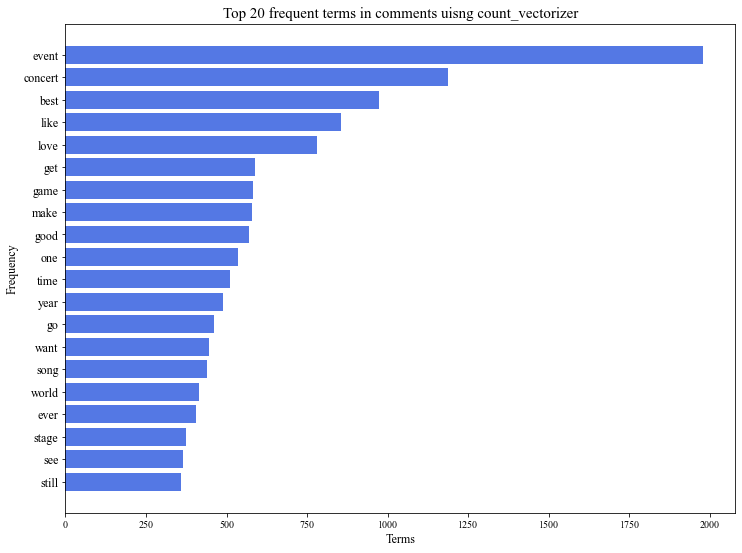

In [46]:
tf_top20 = comment_tf['Count_vectorizer_count'][:20].sort_values(ascending = True)
y_pos = np.arange(20).astype(int)
plt.figure(figsize=(12,9))
plt.barh(y_pos, tf_top20, align='center', color = "royalblue", alpha=0.9)
plt.yticks(y_pos, labels = tf_top20.index, size = 12)
plt.ylabel('Frequency', size = 12)
plt.xlabel('Terms', size = 12)
plt.title('Top 20 frequent terms in comments uisng count_vectorizer', size = 15)
plt.show()
#plt.savefig('Top 40 frequent terms.png', bbox_inches='tight')

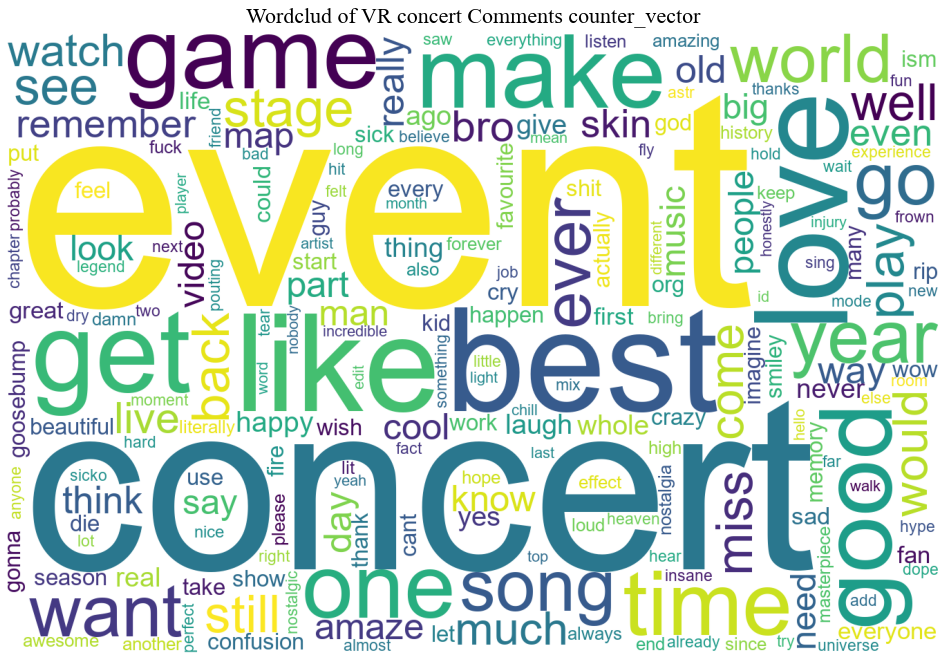

In [47]:
# Make the Worldcoud with the Count_vectorizer_count
wc = WordCloud(font_path='arial',
               background_color='white', 
                max_words=200,
                width=1350, height=900,
              stopwords = man_stop_words)
wc.generate_from_frequencies(comment_tf['Count_vectorizer_count'])
plt.figure(figsize=(13.5,9))
plt.title('Wordclud of VR concert Comments counter_vector', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
#plt.savefig('wordcloud_counter_vector.png', bbox_inches='tight')

## 2.4 Result with the TF-IDF model(Main model)

In [34]:
# Fit the data
tfid = TfidfVectorizer(stop_words = man_stop_words, ngram_range=(1, 1))
tfid_fit = tfid.fit_transform(df_vr_wb_2)

In [57]:
# TF-IDF score table(1gram)
tfid_vec = tfid.transform(df_vr_wb_2)
word_list = tfid.get_feature_names()
count_list = tfid_vec.toarray().sum(axis=0)
tfidf_score_df = pd.DataFrame(count_list, word_list).sort_values(by = [0], ascending = False)
tfidf_score_df.columns = ["tf_idf_score"]
tfidf_score_df

,tf_idf_score
event,476.724533
best,354.529468
concert,321.803416
love,305.934645
like,210.532912
...,...
outcome,0.094638
soulless,0.094638
fuel,0.094638
endeavour,0.094638


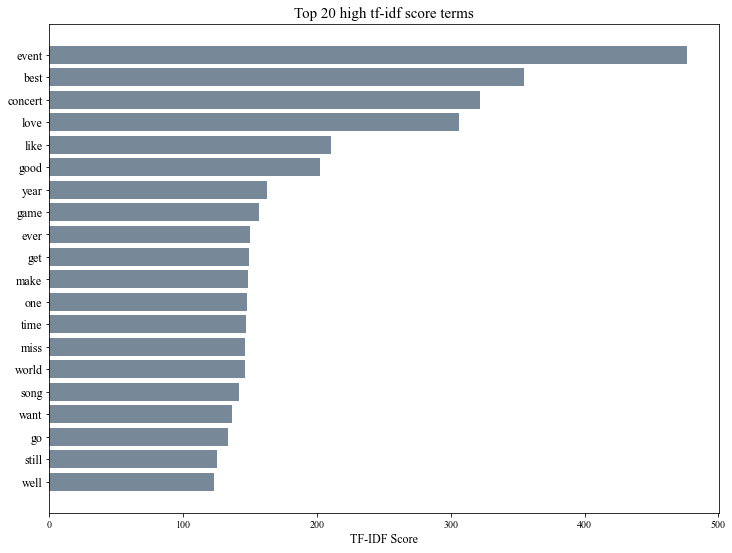

In [38]:
top_20 = tfidf_score_df["tf_idf_score"][:20].sort_values(ascending = True)
y_pos = np.arange(len(top_20)).astype(int)
plt.figure(figsize=(12, 9))
plt.barh(y_pos, top_20, align='center', alpha = 1, color = "lightslategrey")
#plt.xticks(y_pos, rotation=90, size = 15)
plt.yticks(y_pos, labels = top_20.index, size = 12)
#plt.ylabel('Terms', size = 12)
plt.xlabel('TF-IDF Score', size = 12)
plt.title('Top 20 high tf-idf score terms', size = 15)
plt.show()
#plt.savefig('Top 20 high tf-idf score terms.png', bbox_inches='tight')

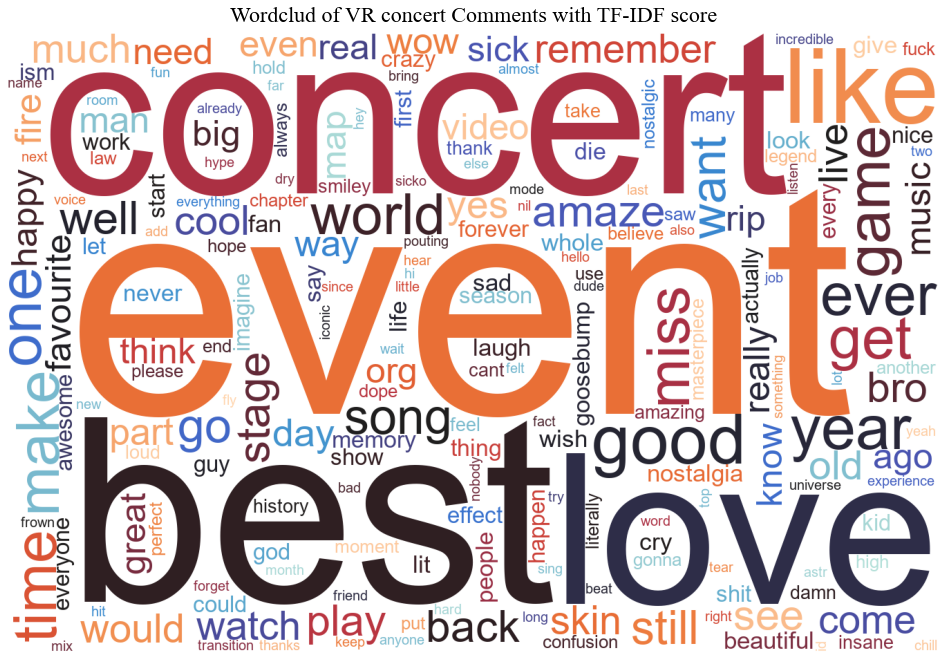

In [39]:
# Tf-Idf Worldcoud
wc = WordCloud(font_path='arial',
               background_color='white', 
                max_words=200,
                width=1350, height=900,
              stopwords = man_stop_words,
               colormap='icefire_r')
wc.generate_from_frequencies(tfidf_score_df['tf_idf_score'])
plt.figure(figsize=(13.5,9))
plt.title('Wordclud of VR concert Comments with TF-IDF score', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
#plt.savefig('wordcloud_tf_idf.png', bbox_inches='tight')

In [58]:
tfidf_score_df.reset_index(inplace = True, drop = False)
tfidf_score_df["TF-IDF Score Rank"] = tfidf_score_df.index + 1
tfidf_score_df.rename(columns = {"index":"Terms"}, inplace = True)
tfidf_score_df

,Terms,tf_idf_score,TF-IDF Score Rank
0,event,476.724533,1
1,best,354.529468,2
2,concert,321.803416,3
3,love,305.934645,4
4,like,210.532912,5
...,...,...,...
4135,outcome,0.094638,4136
4136,soulless,0.094638,4137
4137,fuel,0.094638,4138
4138,endeavour,0.094638,4139


In [60]:
comment_tf.reset_index(inplace = True, drop = False)
comment_tf["Term Frequecny Rank"] = comment_tf.index + 1
comment_tf

,Terms,Count_vectorizer_count,Term Frequecny Rank
0,event,1979,1
1,concert,1187,2
2,best,972,3
3,like,856,4
4,love,780,5
...,...,...,...
4135,occur,1,4136
4136,william,1,4137
4137,kerala,1,4138
4138,tablet,1,4139


In [61]:
tfidf_score_df = pd.merge(tfidf_score_df, comment_tf, how = "outer")[:15]
tfidf_score_df
#tfidf_score_df[:20].to_csv("tf-idf.csv", index = False)

,Terms,tf_idf_score,TF-IDF Score Rank,Count_vectorizer_count,Term Frequecny Rank
0,event,476.724533,1,1979,1
1,best,354.529468,2,972,3
2,concert,321.803416,3,1187,2
3,love,305.934645,4,780,5
4,like,210.532912,5,856,4
5,good,202.109427,6,571,9
6,year,162.534553,7,489,12
7,game,156.362078,8,582,7
8,ever,150.263589,9,406,17
9,get,149.091864,10,588,6


## 2.5 Compariosn of TF-IDF socre with different classes

In [62]:
# Seprate comments by class

df_all = df['comment_clean_2'].reset_index(drop = True)
df_all = df_all[df_all != '']
df_all = df_all[df_all != 'error'].astype("str")
df_all = df_all.apply(after_process)
df_all = df_all.reset_index(drop = True).to_list()

df_general = df['comment_clean_2'][df['comment_clean_2'].notnull()][df["class"] != "vr_concert"].reset_index(drop = True)
df_general = df_general[df_general != '']
df_general = df_general[df_general != 'error'].astype("str")
df_general = df_general.apply(after_process)
df_general = df_general.reset_index(drop = True).to_list()

df_vr_wb = df_vr_wb_2.to_list()

In [63]:
# Fit each coprus to TF-IDF vectorizer
### fit general concert videos
tfid = TfidfVectorizer(stop_words = man_stop_words, ngram_range=(1, 1))
general_tfid_fit = tfid.fit_transform(df_general)

general_tfid_vec = tfid.transform(df_general)
general_word_list = tfid.get_feature_names()
general_count_list = general_tfid_fit.toarray().sum(axis=0)
general_tfidf_score_df = pd.DataFrame(general_count_list, general_word_list).sort_values(by = [0], ascending = False)
general_tfidf_score_df.columns = ["tf_idf_score_general"]
general_tfidf_score_df[:20]

,tf_idf_score_general
love,1512.428797
song,691.060725
voice,569.962484
best,535.422012
like,475.589131
beautiful,458.188770
performance,403.864281
good,379.855475
live,348.208795
one,339.570340


In [64]:
# TF-IDF score table(1gram)
tfid = TfidfVectorizer(stop_words = man_stop_words, ngram_range=(1, 1))
vr_tfid_fit = tfid.fit_transform(df_vr_wb)

tfid_vec = tfid.transform(df_vr_wb)
word_list = tfid.get_feature_names()
count_list = tfid_vec.toarray().sum(axis=0)
tfidf_score_df = pd.DataFrame(count_list, word_list).sort_values(by = [0], ascending = False)
tfidf_score_df.columns = ["tf_idf_score_vr"]
tfidf_score_df

,tf_idf_score_vr
event,476.724533
best,354.529468
concert,321.803416
love,305.934645
like,210.532912
...,...
outcome,0.094638
soulless,0.094638
fuel,0.094638
endeavour,0.094638


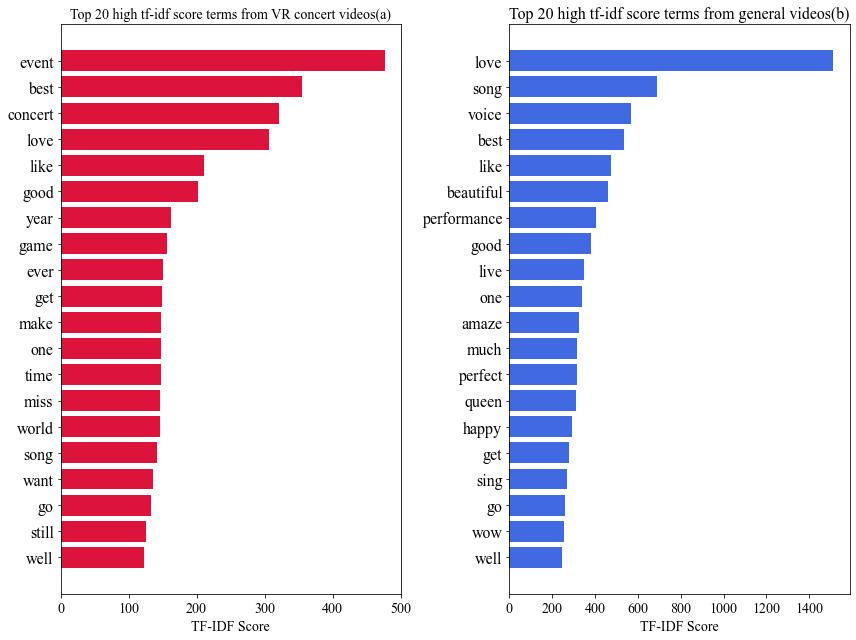

In [65]:
fig = plt.figure(constrained_layout = True, figsize = (12, 9))
grid = plt.GridSpec(1, 2)

#ax = axis.flatten()
ax1 = fig.add_subplot(grid[0])
top_20 = tfidf_score_df["tf_idf_score_vr"][:20].sort_values(ascending = True)
y_pos = np.arange(len(top_20)).astype(int)
plt.barh(y_pos, top_20, align='center', alpha = 1, color = "crimson")
plt.xlabel('TF-IDF Score', size = 14)
plt.xticks(size = 14)
plt.yticks(y_pos, labels = top_20.index, size = 16)
ax1.set_title('Top 20 high tf-idf score terms from VR concert videos(a)', fontsize = 14)

ax2 = fig.add_subplot(grid[1])
top_20 = general_tfidf_score_df["tf_idf_score_general"][:20].sort_values(ascending = True)
y_pos = np.arange(len(top_20)).astype(int)
plt.barh(y_pos, top_20, align='center', alpha = 1, color = "royalblue")
plt.yticks(y_pos, labels = top_20.index, size = 16)
plt.xticks(size = 14)
plt.xlabel('TF-IDF Score', size = 14)
ax2.set_title('Top 20 high tf-idf score terms from general videos(b)', fontsize = 16)

#plt.suptitle("TF-IDF score comparsion bettwen VR concert videos and general concert videos", fontsize = 17)
plt.tight_layout()
plt.show()
#plt.savefig('Top 20 high tf-idf score comparison.png', bbox_inches='tight')

# 3. Topic extraction with BERTopic
As BERTtopic is transformer base model and can calculate the context of the sentence, it is suggested to keep the original shape of the data. 
<br>Therefore, I will not use the spell check and manually added stop words for topic modeling.
<br>But ajdust some parameter in countervectoreizer and C-TF-IDF.
- CountVectorizer(stop_words="english")
- ClassTfidfTransformer(reduce_frequent_words=True)

## 3.1 Pre-process for BERTopic modeling

In [118]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""
EMOTICONS = {
    u":‑\)":"Happy or smiley",
    u":\)":"Happy or smiley",
    u":-\]":"Happy or smiley",
    u":\]":"Happy or smiley",
    u":-3":"Happy smiley",
    u":3":"Happy smiley",
    u":->":"Happy smiley",
    u":>":"Happy smiley",
    u"8-\)":"Happy smiley",
    u":o\)":"Happy smiley",
    u":-\}":"Happy smiley",
    u":\}":"Happy smiley",
    u":-\)":"Happy smiley",
    u":c\)":"Happy smiley",
    u":\^\)":"Happy smiley",
    u"=\]":"Happy smiley",
    u"=\)":"Happy smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [119]:
# Preparing for the tool
##1. Remove url, user menthions
def remove_mentions_hash(text):
    text = str(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URL
    text = re.sub(r'#', '', text) #Change hashtag text to normal text
    text = re.sub(r'^@', '', text) #Remove user-mention text
    return text

#2. Change emoticons to words
import emot 
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

#3. Chat words conversion to normal words
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)
    
#4,5 . Expand contractino and change elongate
import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
text_processor = TextPreProcessor(
    annotate={"elongated"},
    fix_html=True,
    segmenter="twitter", 
    corrector="twitter", 
    unpack_hashtags=False,
    unpack_contractions = True, 
    spell_correct_elong = False,
    remove_tags = True
)
def expan_elongat(text):
    text = text
    return text_processor.pre_process_doc(text)

#6. Remove Puncutation
punct_list = string.punctuation
def remove_punctuation(text):
    text = re.sub('\s+', ' ', text)
    return text.translate(str.maketrans('', '', punct_list))

#7. Lower Case
def lower_text(text):
    text = text.lower()
    return text

#8. Word Segmentation
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def word_segment(text):
    text = text
    result = sym_spell.word_segmentation(text)
    return(result.corrected_string)

#9. Remove Number
def remove_num(text):
    text = re.sub(r'([0-9]+)', '', text)
    return text

#10. Remove Stop Words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

#11. Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


def shorttext_preporcessor_for_bertopic(text):
    try:
        text = remove_mentions_hash(text)
        text = convert_emoticons(text)
        text = chat_words_conversion(text)
        text = expan_elongat(text)
        text = remove_punctuation(text)
        text = lower_text(text)
        text = word_segment(text)
        text = remove_num(text)
        text = remove_stopwords(text)
        text = lemmatize_words(text)
    except:
        return "error"
    return text

Reading twitter - 1grams ...


In [366]:
df["comment_bertpic"] = df["Comment_en"].apply(shorttext_preporcessor_for_bertopic)

In [3]:
df = pd.read_csv("cleaned_comment_data_fin.csv", encoding = 'utf-8-sig')

In [628]:
# Check the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37771 entries, 0 to 37770
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Comment          37771 non-null  object
 1   Comment_date     37771 non-null  int64 
 2   Likes            37771 non-null  int64 
 3   class            37771 non-null  object
 4   singer           37771 non-null  object
 5   Comment_en       37771 non-null  object
 6   en               37771 non-null  int64 
 7   comment_clean_1  36224 non-null  object
 8   comment_clean_2  36785 non-null  object
 9   comment_clean_3  36795 non-null  object
 10  comment_clean_4  36544 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.2+ MB


In [631]:
df = df[df['comment_clean_2'].notnull()]
df = df[df['comment_clean_2'] !=""]
df = df[df['comment_clean_2'] !="error"]
df.reset_index(drop = True, inplace = True)
df.drop(columns = ["comment_clean_1", "comment_clean_3", "comment_clean_4"], inplace = True)
df.rename(columns = {"comment_clean_2": "comment_clean"}, inplace = True)

In [638]:
# Manually modified misspled terms
df["comment_clean"] = df["comment_clean"].str.replace("fort nite", "fortnite") 
df["comment_clean"] = df["comment_clean"].str.replace("footnote", "fortnite") 
df["comment_clean"] = df["comment_clean"].str.replace("fortnight", "fortnite") 
df["comment_clean"] = df["comment_clean"].str.replace("footbal", "fortnite") 

df["comment_clean"] = df["comment_clean"].str.replace("scott", "scoot")

df["comment_clean"] = df["comment_clean"].str.replace("marshmallows", "marshmello")
df["comment_clean"] = df["comment_clean"].str.replace("marshmallow", "marshmello")

df["comment_clean"] = df["comment_clean"].str.replace("mariana", "ariana")

df["comment_clean"] = df["comment_clean"].str.replace("meta verse", "metaverse")
df["comment_clean"] = df["comment_clean"].str.replace("yr", "year")

print("Number of comments:",len(df["comment_clean"]))

Number of comments: 36485


In [639]:
# Save again the cleaned data for Topic Modeling

df.to_csv("cleaned_comment_data_final.csv", index = False, encoding = "utf-8-sig")

In [4]:
df = pd.read_csv("cleaned_comment_data_final.csv", encoding = 'utf-8-sig')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36485 entries, 0 to 36484
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Comment        36485 non-null  object
 1   Comment_date   36485 non-null  int64 
 2   Likes          36485 non-null  int64 
 3   class          36485 non-null  object
 4   singer         36485 non-null  object
 5   Comment_en     36485 non-null  object
 6   en             36485 non-null  int64 
 7   comment_clean  36485 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.2+ MB


In [7]:
vr_topic_data = df["comment_clean"][df["class"] == "vr_concert"].copy().to_list()
vr_topic_data[:10]

['alright play fortnite anymore admit one best event game history',
 'best event time lot memory',
 'deus insane get great visuals live game big',
 'amaze miss time love season map time play game',
 'remember first event saw memory',
 'go soon hard right straight banger int like artist go ham gram u dat rocket get follower gram like island boy dun',
 'marshmello get stage get space galactic get entire multiverse',
 'even year still best event question',
 'nostalgia',
 'love event']

In [6]:
df_whole = df["comment_clean"].copy().to_list()
df_whole[:10]

['alright play fortnite anymore admit one best event game history',
 'best event time lot memory',
 'deus insane get great visuals live game big',
 'amaze miss time love season map time play game',
 'remember first event saw memory',
 'go soon hard right straight banger int like artist go ham gram u dat rocket get follower gram like island boy dun',
 'marshmello get stage get space galactic get entire multiverse',
 'even year still best event question',
 'nostalgia',
 'love event']

In [ ]:
#!pip install plotly==5.3.1
#!pip install keybert
#pip install --upgrade "kaleido==0.1.*"

In [48]:
import plotly
import plotly.io as pio
pio.renderers.default = "svg"
import kaleido 

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from bertopic.backend import languages
from keybert import KeyBERT

In [339]:
# Pre- Embedding
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(vr_topic_data, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## 3.2 Set the model

### 3.2.1 Parameter Explanation
from https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
- Umap
    - n_neighbors 
        - n_neighbors is the number of neighboring sample points used when making the manifold approximation. 
        - Increasing this value typically results in a more global view of the embedding structure whilst smaller values result in a more local view. Increasing this value often results in larger clusters being created.
    - n_components 
        - n_components refers to the dimensionality of the embeddings after reducing them. This is set as a default to 5 to reduce dimensionality as much as possible whilst trying to maximize the information kept in the resulting embeddings. 
        - Although lowering or increasing this value influences the quality of embeddings, its effect is largest on the performance of HDBSCAN. 
        - Increasing this value too much and HDBSCAN will have a hard time clustering the high-dimensional embeddings. Lower this value too much and too little information in the resulting embeddings are available to create proper clusters. If you want to increase this value, I would advise setting using a metric for HDBSCAN that works well in high dimensional data.
    
- HDBSCAN
    - min_cluster_size 
        - min_cluster_size is arguably the most important parameter in HDBSCAN. It controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. 
        - Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. 
        - Typically, I would advise increasing this value rather than decreasing it.
    - min_samples 
        - min_samples is automatically set to min_cluster_size and controls the number of outliers generated. 
        - Setting this value significantly lower than min_cluster_size might help you reduce the amount of noise you will get. Do note that outliers are to be expected and forcing the output to have no outliers may not properly represent the data
    
- BERTopic
    - top_n_words 
        - top_n_words refers to the number of words per topic that you want to be extracted. 
        - In practice, I would advise you to keep this value below 30 and preferably between 10 and 20. 
        - The reasoning for this is that the more words you put in a topic the less coherent it can become. The top words are the most representative of the topic and should be focused on.
    - min_topic_size 
        - min_topic_size is an important parameter! It is used to specify what the minimum size of a topic can be. 
        - The lower this value the more topics are created. If you set this value too high, then it is possible that simply no topics will be created! Set this value too low and you will get many microclusters. 
        - It is advised to play around with this value depending on the size of your dataset. If it nears a million documents, then it is advised to set it much higher than the default of 10, for example, 100 or even 500.
    - nr_topics 
        - nr_topics can be a tricky parameter. It specifies, after training the topic model, the number of topics that will be reduced. For example, if your topic model results in 100 topics but you have set nr_topics to 20 then the topic model will try to reduce the number of topics from 100 to 20. 
        - This reduction can take a while as each reduction in topics activates a c-TF-IDF calculation. If this is set to None, no reduction is applied. Use "auto" to automatically reduce topics using HDBSCAN.

### 3.2.2 Bigram Model

In [279]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors = 5,  # bigram :5
                  n_components = 5, # bigram :5
                  metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size = 30,  # bigram : 30
                        min_samples = 10, # bigram :10
                        metric='euclidean', cluster_selection_method='eom', 
                        gen_min_span_tree=True,
                        prediction_data=True)
# Step 4 - Tokenize topics
#stop_words = stop_words
vectorizer_model = CountVectorizer(ngram_range = (1, 2), stop_words = "english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words = False)

In [284]:
topic_model_bigram = BERTopic(
    #embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    diversity= 0.5,                      # Step 6 - Diversify topic words
    calculate_probabilities = False,
    top_n_words = 12, #15*** - 10
    language = "english",
    n_gram_range = (1, 2),
    min_topic_size = 10, #10 - 15
    nr_topics = "auto"
)
topic_model_bigram.save("bigram_model")

C:\Users\kjkoo\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



### 3.2 Fit the model and Get the topic from vr_concert comments

In [297]:
topics, probs = topic_model_bigram.fit_transform(vr_topic_data, embeddings)

In [298]:
topics = topic_model_bigram.get_topic_info()
topics

,Topic,Count,Name
0,-1,2320,-1_concert_fortnite_event_like
1,0,2266,0_stage_event_marshmello_fortnite
2,1,491,1_ariana_ariana grand_grand_love ariana
3,2,263,2_song_music_listen_best music
4,3,213,3_rip_die_rip world_die concert
...,...,...,...
66,65,32,65_oil_oil oil_cat_kick
67,66,32,66_code_paul_marcelo_chap
68,67,32,67_astr_astr world_world_vibe
69,68,30,68_virus_corona_corona virus_quarantine


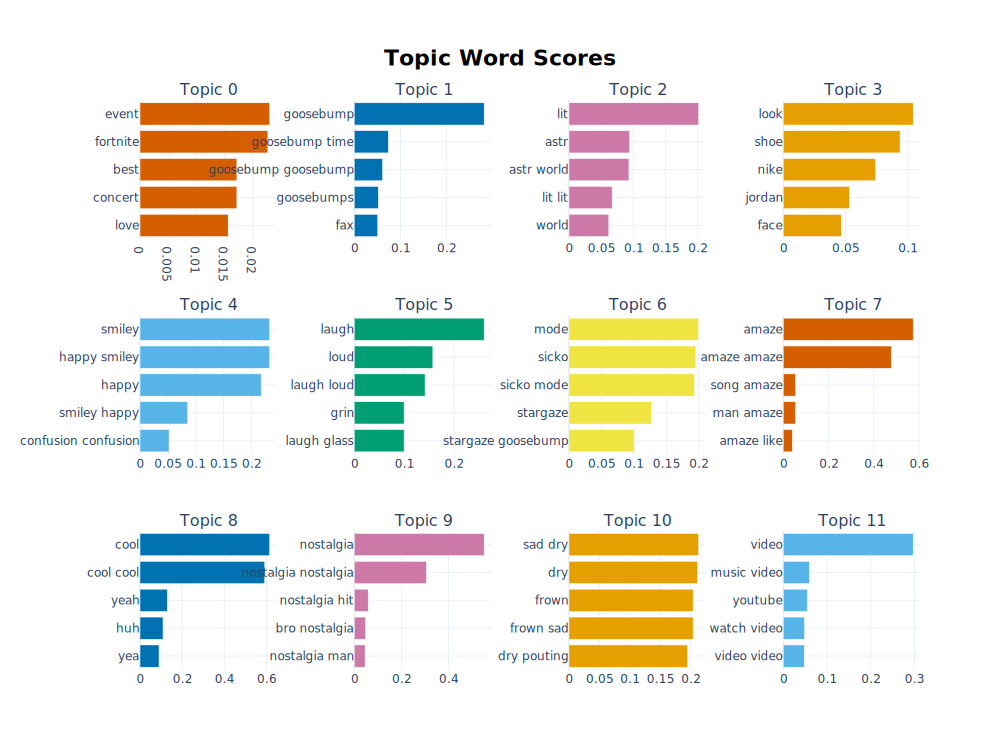

In [296]:
topic_model_bigram.visualize_barchart(top_n_topics=12)

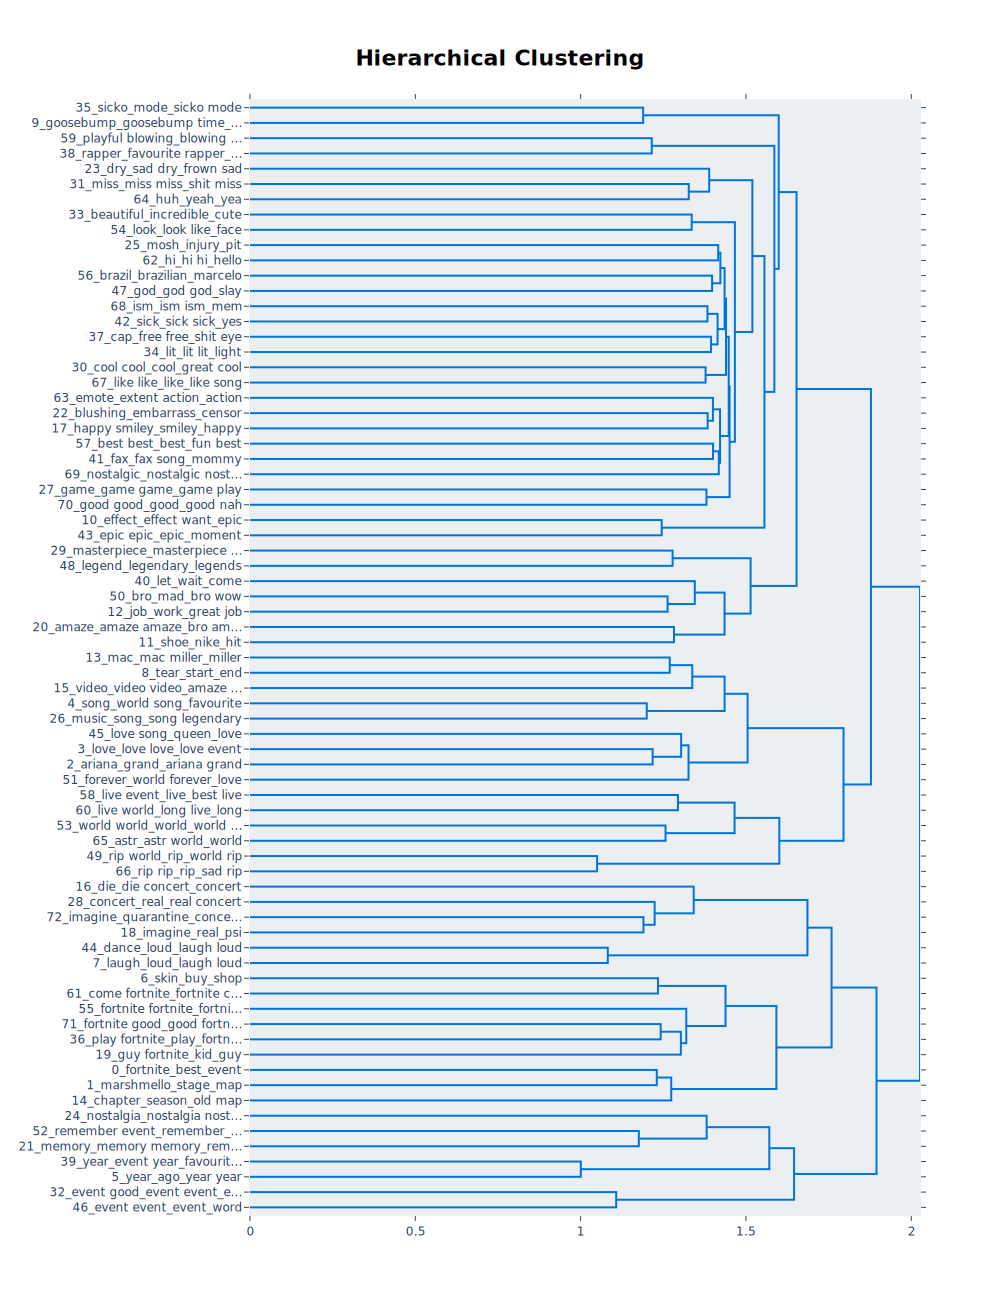

In [292]:
topic_model_bigram.visualize_hierarchy()

In [86]:
topic_model_bigram.reduce_topics(vr_topic_data, nr_topics= 'auto')

In [328]:
fig = topic_model_bigram.visualize_barchart(top_n_topics = 12, width = 240, height = 310)
#fig.show()
fig.write_image('visualize_barchart_bigram.png', engine='kaleido')

In [339]:
fig = topic_model_bigram.visualize_hierarchy()
#fig.show()
fig.write_image('visualize_hierarchy_bigram.png', engine='kaleido')

In [154]:
topic_model_bigram.get_topic(2)

[('concert', 0.05778915272367553),
 ('virtual', 0.034750903393644346),
 ('virtual concert', 0.03320441142621328),
 ('die', 0.02708992219682737),
 ('die concert', 0.023318447272314857),
 ('real', 0.021524932219636587),
 ('concert like', 0.02128958940886648),
 ('concert concert', 0.019172194740630782),
 ('like', 0.017554202507660186),
 ('safe', 0.016996424034478246)]

In [331]:
topics_val = topics.loc[1:]
topics_val.to_csv("topic_bigram.csv", index = False, encoding = 'utf-8-sig')

In [340]:
topic_index = [x for x in topics_val["Name"]]
base = pd.DataFrame([topic_model_bigram.get_topic(0)])
for i in range(len(topics_val)-1):
    base = pd.concat([base, pd.DataFrame([topic_model_bigram.get_topic(i)])])
#base.columns = [x for x in topic_10["Name"]]
base.index = [x for x in topics_val["Name"]]
base["topic_name"] = base.index
topic_bigram = base.replace('', np.nan).set_index('topic_name').stack().reset_index(name='Terms').drop('level_1',1)
topic_bigram
topic_bigram.to_csv("get_topic_bigram.csv", encoding = "utf-8-sig", index = False)

In [341]:
topic_index = [x for x in topics_val["Name"]]
base = pd.DataFrame([topic_model_bigram.get_representative_docs(0)])
for i in range(len(topics_val)-1):
    base = pd.concat([base, pd.DataFrame([topic_model_bigram.get_representative_docs(i)])])
#base.columns = [x for x in topic_10["Name"]]
base.index = [x for x in topics_val["Name"]]
base["topic_name"] = base.index
topic_represn_bigram = base.replace('', np.nan).set_index('topic_name').stack().reset_index(name='Represent Docs').drop('level_1',1)
topic_represn_bigram
topic_represn_bigram.to_csv("represent_docs_bigram.csv", encoding = "utf-8-sig", index = False)

In [350]:
pd.concat([topics_val, topic_bigram, topic_represn_bigram])

,Topic,Count,Name,topic_name,Terms,Represent Docs
1,0.0,715.0,0_best_fortnite_best event_event,NaN,NaN,NaN
2,1.0,456.0,1_ariana_ariana grand_grand_love ariana,NaN,NaN,NaN
3,2.0,372.0,2_love_love love_job_play fortnite,NaN,NaN,NaN
4,3.0,341.0,3_stage_epic_map_epic game,NaN,NaN,NaN
5,4.0,339.0,4_year_ago_remember_year ago,NaN,NaN,NaN
...,...,...,...,...,...,...
304,NaN,NaN,NaN,77_rift_rift tour_tour_goddess,NaN,mar hello hama suckers one beat show hold drug
305,NaN,NaN,NaN,77_rift_rift tour_tour_goddess,NaN,look future concert
306,NaN,NaN,NaN,78_favourite event_favourite_year event_year,NaN,rift tour feature ariana grand mesmerize great...
307,NaN,NaN,NaN,78_favourite event_favourite_year event_year,NaN,ariana grand spectacular please rift tour


In [374]:
topic_df = pd.merge(topics_val, topic_bigram, how = 'inner', left_on = "Name", right_on = "topic_name")
topic_df = pd.merge(topic_df, topic_represn_bigram, how = 'inner')
topic_df.drop(["topic_name"], axis = 1, inplace = True)
topic_df.to_csv("topic_df.csv", encoding = "utf-8-sig", index = False)

In [373]:
topic_df.columns - ["Name"]

TypeError: Cannot broadcast np.ndarray with operand of type <class 'list'>

### 3.2.3 One Gram Model

In [190]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors = 7, # 7 - 8*** # bigram :5
                  n_components = 6, # Higher than 5 - 6***  # bigram :5
                  metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size =30, # 30*** - 10 - 40 - 25 # bigram : 30
                        min_samples = 5, #5*** < <10 # bigram :10
                        metric='euclidean', cluster_selection_method='eom', 
                        gen_min_span_tree=True,
                        prediction_data=True)
# Step 4 - Tokenize topics
#stop_words = stop_words
vectorizer_model = CountVectorizer(ngram_range = (1, 1), stop_words = "english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words = False)

In [195]:
topic_model_one_gram = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    diversity= 0.6,                      # Step 6 - Diversify topic words
    calculate_probabilities = False,
    top_n_words = 15, #15*** - 10
    language = "english",
    n_gram_range = (1, 1),
    min_topic_size = 10, #10 - 15
    nr_topics = "auto"
)
topic_model_one_gram.save("one_gram_model")

C:\Users\kjkoo\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [196]:
topics, probs = topic_model_one_gram.fit_transform(vr_topic_data, embeddings)

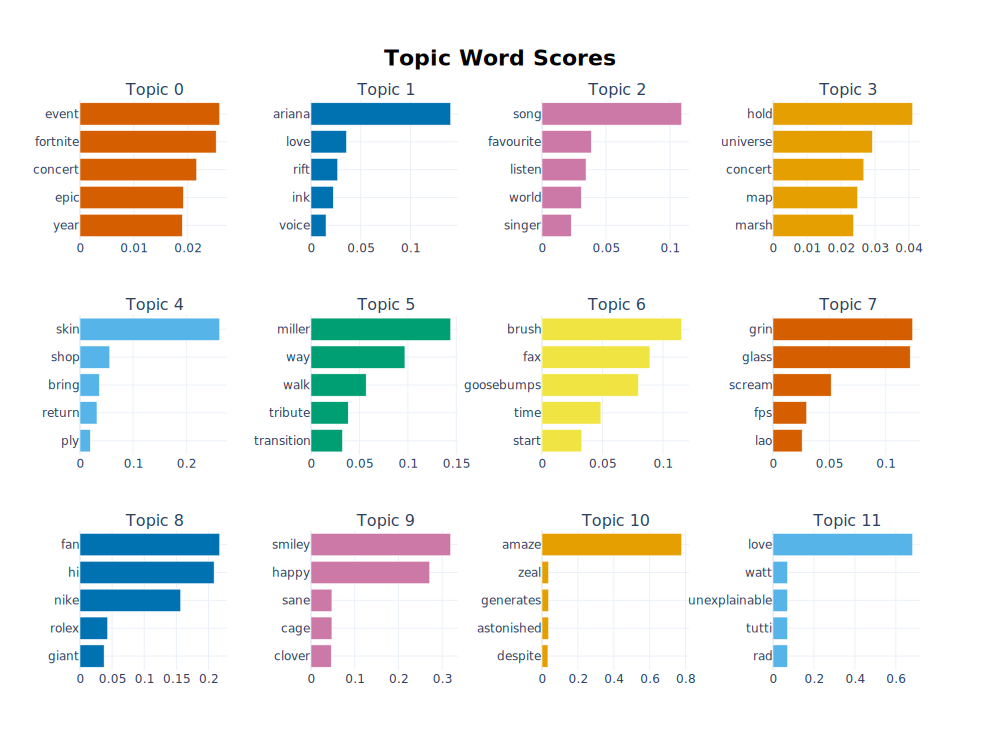

In [198]:
topic_model_one_gram.visualize_barchart(top_n_topics=12)

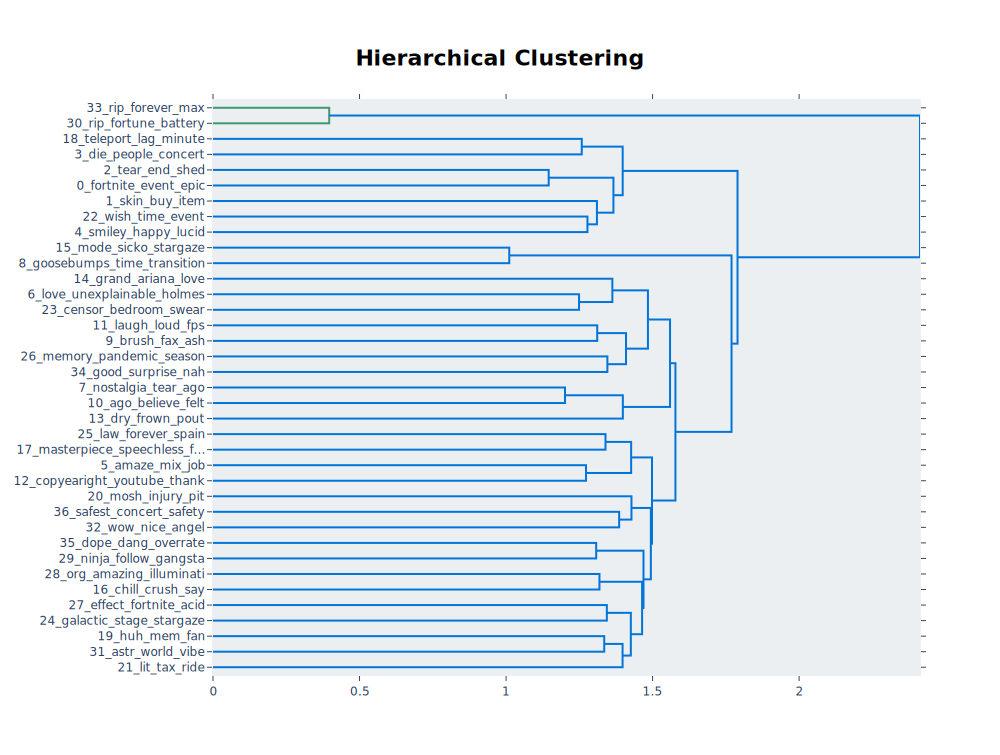

In [223]:
topic_model_one_gram.visualize_hierarchy()

### 3.2.4 Keybert & BERTopic(Main Model)

In [340]:
from keybert import KeyBERT

# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(vr_topic_data)

# Create our vocabulary for concentrate on local data
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

In [806]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors = 7, # 8 -> 7
                  n_components = 4, # 5 -> 4
                  metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size = 30,# 30
                        min_samples = 6, #5*** -> 6
                        metric='euclidean', cluster_selection_method='eom', 
                        gen_min_span_tree=True,
                        prediction_data=True)
# Step 4 - Tokenize topics
#stop_words = stop_words
vectorizer_model = CountVectorizer(vocabulary=vocabulary, stop_words = "english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words = False)

In [807]:
topic_key_model = BERTopic(
    #embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    diversity= 0.55,                      # Step 6 - Diversify topic words
    calculate_probabilities = False,
    top_n_words = 15, #15***
    language = "english",
    n_gram_range = (1, 1),
    min_topic_size = 10, #10 - 15
    nr_topics = "auto"
)
topic_key_model.save("key_model")

In [820]:
topics, probs = topic_key_model.fit_transform(vr_topic_data, embeddings)

In [958]:
topics = topic_key_model.get_topic_info()
topics

,Topic,Count,Name
0,-1,2182,-1_event_fortnite_like_world
1,0,856,0_marshmello_stage_epic_map
2,1,664,1_year_ago_nostalgia_memory
3,2,567,2_ariana_grand_arianas_love
4,3,538,3_fortnite_best_event_concert
5,4,463,4_amaze_masterpiece_cool_best
6,5,442,5_song_music_listen_world
7,6,356,6_concert_real_imagine_virtual
8,7,242,7_rip_die_world_people
9,8,222,8_miss_old_map_sad


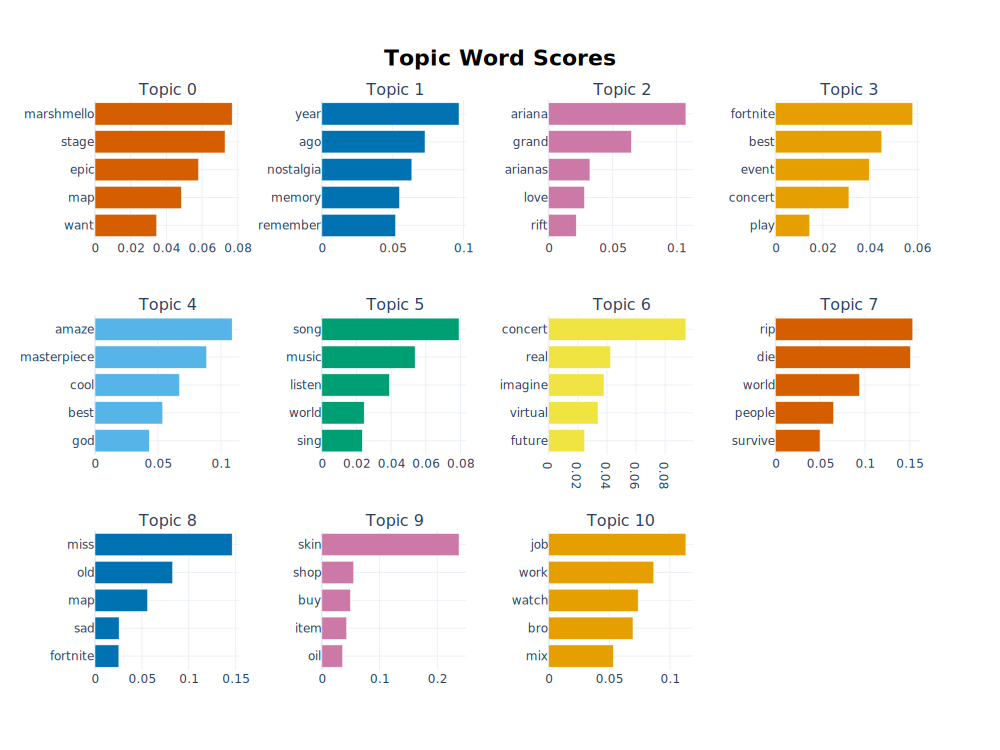

In [959]:
topic_key_model.visualize_barchart(top_n_topics = 11)

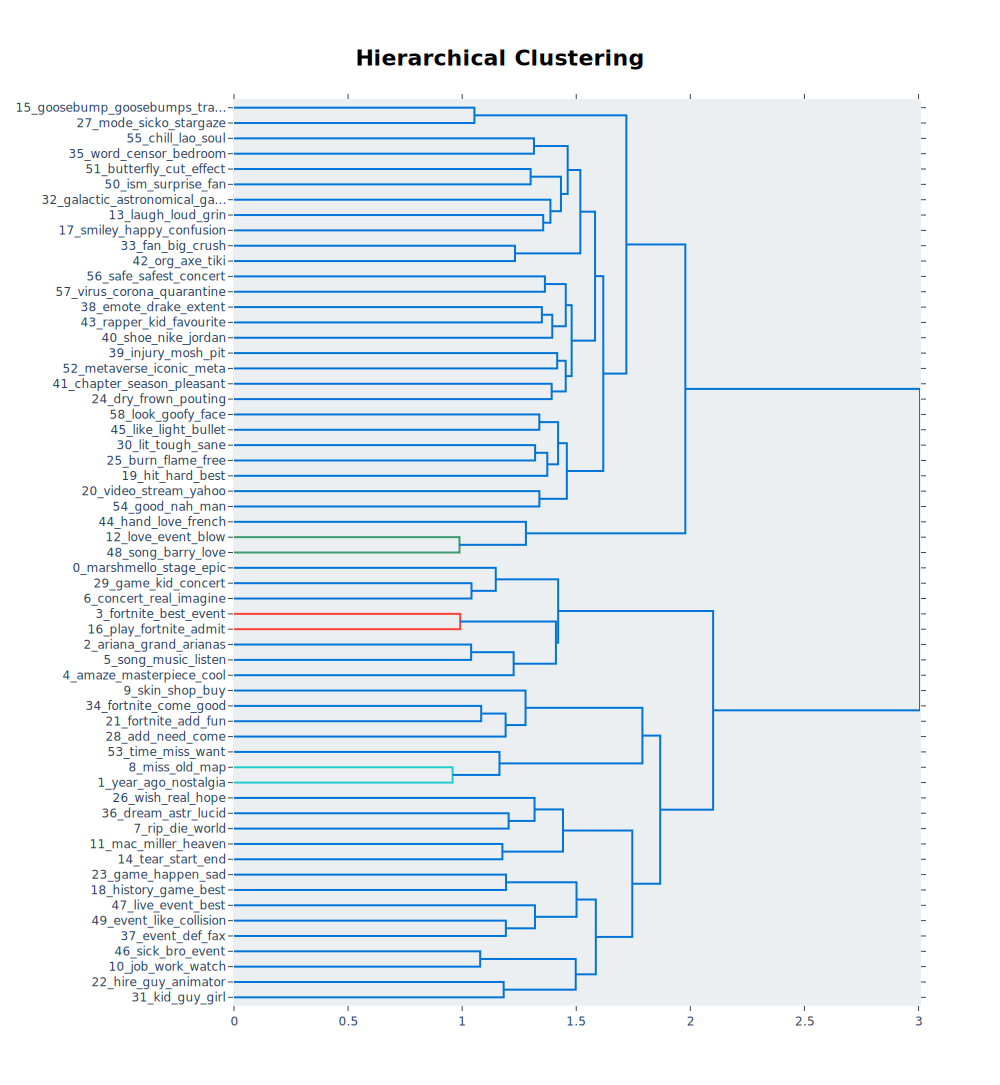

In [960]:
topic_key_model.visualize_hierarchy()

In [957]:
# Merge the relavent topics together

topics_to_merge = [[2, 74],
                  [3, 5, 9, 66],
                  [4, 57],
                  [7, 12, 24, 32, 41, 45, 80],
                  [10, 58],
                  [13, 46],
                  [14, 25, 79],
                  [16, 36],
                  [27, 28, 35, 40, 42, 55, 60, 67],
                  [37, 70]]
topic_key_model.merge_topics(vr_topic_data, topics_to_merge)

In [836]:
fig = topic_key_model.visualize_barchart(top_n_topics = 11, width = 240, height = 310)
#fig.show()
fig.write_image('visualize_barchart_keybert.png', engine='kaleido')

In [961]:
fig = topic_key_model.visualize_barchart(top_n_topics = 12, width = 240, height = 310)
#fig.show()
fig.write_image('visualize_barchart_keybert_merged.png', engine='kaleido')

In [837]:
fig = topic_key_model.visualize_hierarchy()
#fig.show()
fig.write_image('visualize_hierarchy_keybert.png', engine='kaleido')

In [167]:
#topic_key_model.reduce_topics(vr_topic_data, nr_topics= 'auto')

In [966]:
topic_key_model.get_topic(4)

[('amaze', 0.10884103985325802),
 ('masterpiece', 0.08857536406340782),
 ('cool', 0.06707451040624783),
 ('best', 0.053717532000811224),
 ('god', 0.043084128622310196),
 ('beautiful', 0.03830744894952905),
 ('incredible', 0.03700829905684109),
 ('event', 0.03280682333231349),
 ('perfect', 0.026022275978581505),
 ('concert', 0.021662085320966334),
 ('great', 0.020408500351037633),
 ('good', 0.019584022234641982),
 ('absolutely', 0.01875301797695368),
 ('sheet', 0.018156734842270886),
 ('wonderful', 0.01729853008837881)]

In [721]:
topic_key_model.get_representative_docs(42)

['imagine censor word molly',
 'imagine see person glitching around everywhere',
 'good job would think real one told']

In [990]:
topics_val = topics.loc[1:]
topics_val.head()

,Topic,Count,Name
1,0,856,0_marshmello_stage_epic_map
2,1,664,1_year_ago_nostalgia_memory
3,2,567,2_ariana_grand_arianas_love
4,3,538,3_fortnite_best_event_concert
5,4,463,4_amaze_masterpiece_cool_best


In [989]:
topic_index = [x for x in topics_val["Name"]]
get_topic = pd.DataFrame([topic_key_model.get_topic(0)])
for i in range(1, len(topic_index)):
    get_topic = pd.concat([get_topic, pd.DataFrame([topic_key_model.get_topic(i)])], axis = 0)
get_topic.index = topic_index
get_topic_vertical = get_topic.stack().reset_index(name='Terms').drop('level_1',1)
get_topic_vertical.rename(columns = {"level_0": "topic_name"}, inplace = True)
get_topic_vertical
get_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0_marshmello_stage_epic_map,"(marshmello, 0.07689153075748903)","(stage, 0.07290772906293674)","(epic, 0.058043232209988506)","(map, 0.04837200898452056)","(want, 0.0345767588355189)","(effect, 0.028279254721992487)","(yes, 0.028060176887952985)","(universe, 0.02531981670728354)","(use, 0.022929929369119365)","(game, 0.02143365717651863)","(build, 0.019599353705129736)","(hold, 0.019173953555653146)","(planet, 0.017305458665693635)","(big, 0.014357109735537587)","(make, 0.014281202710691339)"
1_year_ago_nostalgia_memory,"(year, 0.09676761234038583)","(ago, 0.07276909767331236)","(nostalgia, 0.06348344387294415)","(memory, 0.05475446064329292)","(remember, 0.0519856383112393)","(old, 0.03696666898424936)","(believe, 0.03481230317069754)","(day, 0.03120332551909685)","(nostalgic, 0.030862691712384725)","(month, 0.02669326052528466)","(yesterday, 0.025929937904706137)","(time, 0.025589962405302313)","(forget, 0.01914299345755322)","(good, 0.018645684229581856)","(fly, 0.018614827655660596)"
2_ariana_grand_arianas_love,"(ariana, 0.10733322153570728)","(grand, 0.06464953582250992)","(arianas, 0.0322362982753747)","(love, 0.027923597156181545)","(rift, 0.021513157720571795)","(tour, 0.020873666996227766)","(ink, 0.017267732147794364)","(woman, 0.016671376917497517)","(angel, 0.015223461274902308)","(fan, 0.015173362024749573)","(black, 0.014815634130875397)","(raindrop, 0.014068280288998754)","(ring, 0.013575771246196825)","(goddess, 0.013374884149246485)","(music, 0.013063418767782421)"
3_fortnite_best_event_concert,"(fortnite, 0.058093273879571)","(best, 0.044969024161379836)","(event, 0.03963426118070898)","(concert, 0.031047531139949392)","(play, 0.014440361046868534)","(like, 0.01332984404256829)","(time, 0.012706710508556537)","(far, 0.012672549625224901)","(make, 0.01243613813605213)","(live, 0.012150921920801132)","(season, 0.009924124189842055)","(good, 0.009734259694088908)","(happen, 0.009432177713383918)","(friend, 0.008615540597381158)","(really, 0.008235191879597663)"
4_amaze_masterpiece_cool_best,"(amaze, 0.10884103985325802)","(masterpiece, 0.08857536406340782)","(cool, 0.06707451040624783)","(best, 0.053717532000811224)","(god, 0.043084128622310196)","(beautiful, 0.03830744894952905)","(incredible, 0.03700829905684109)","(event, 0.03280682333231349)","(perfect, 0.026022275978581505)","(concert, 0.021662085320966334)","(great, 0.020408500351037633)","(good, 0.019584022234641982)","(absolutely, 0.01875301797695368)","(sheet, 0.018156734842270886)","(wonderful, 0.01729853008837881)"


In [969]:
topic_index = [x for x in topics_val["Name"]]
base = pd.DataFrame([topic_key_model.get_representative_docs(0)])
for i in range(1, len(topics_val)):
    base = pd.concat([base, pd.DataFrame([topic_key_model.get_representative_docs(i)])])
#base.columns = [x for x in topic_10["Name"]]
base.index = [x for x in topics_val["Name"]]
base["topic_name"] = base.index
topic_represn_key = base.replace('', np.nan).set_index('topic_name').stack().reset_index(name='Represent Docs').drop('level_1',1)
topic_represn_key

,topic_name,Represent Docs
0,0_marshmello_stage_epic_map,marshmello give stage give whole map
1,0_marshmello_stage_epic_map,marshmello get stage get world
2,0_marshmello_stage_epic_map,incredible mind blow marshmello want stage wan...
3,0_marshmello_stage_epic_map,gonna cry nostalgic want another marsh hello c...
4,0_marshmello_stage_epic_map,favourite season ice king marshmello concert
...,...,...
283,57_virus_corona_quarantine_hold,memory perfect season go quarantine concert
284,57_virus_corona_quarantine_hold,actually smart way perform concert quarantine
285,58_look_goofy_face_ash,look like kinda cult
286,58_look_goofy_face_ash,look like guy date kyle jenner


In [970]:
topics_val.to_csv("topic_keybert_merge.csv", index = False, encoding = 'utf-8-sig')
get_topic.to_csv("get_topic_keybert_merge.csv", encoding = "utf-8-sig", index = True)
get_topic_vertical.to_csv("get_topic_keybert_vertical_merge.csv", encoding = "utf-8-sig", index = False)
topic_represn_key.to_csv("represent_docs_keybert_merge.csv", encoding = "utf-8-sig", index = False)

## 3.3 Topics over time

In [828]:
# First, change the int tpye to date time

timestamps = df["Comment_date"][df["class"] == "vr_concert"].astype("str").astype('datetime64[ns]').dt.strftime('%Y')
timestamps.head()

0    2021
1    2022
2    2022
3    2022
4    2022
Name: Comment_date, dtype: object

In [973]:
topics_over_time = topic_key_model.topics_over_time(vr_topic_data, timestamps, datetime_format = "%Y", global_tuning = True, evolution_tuning = True)

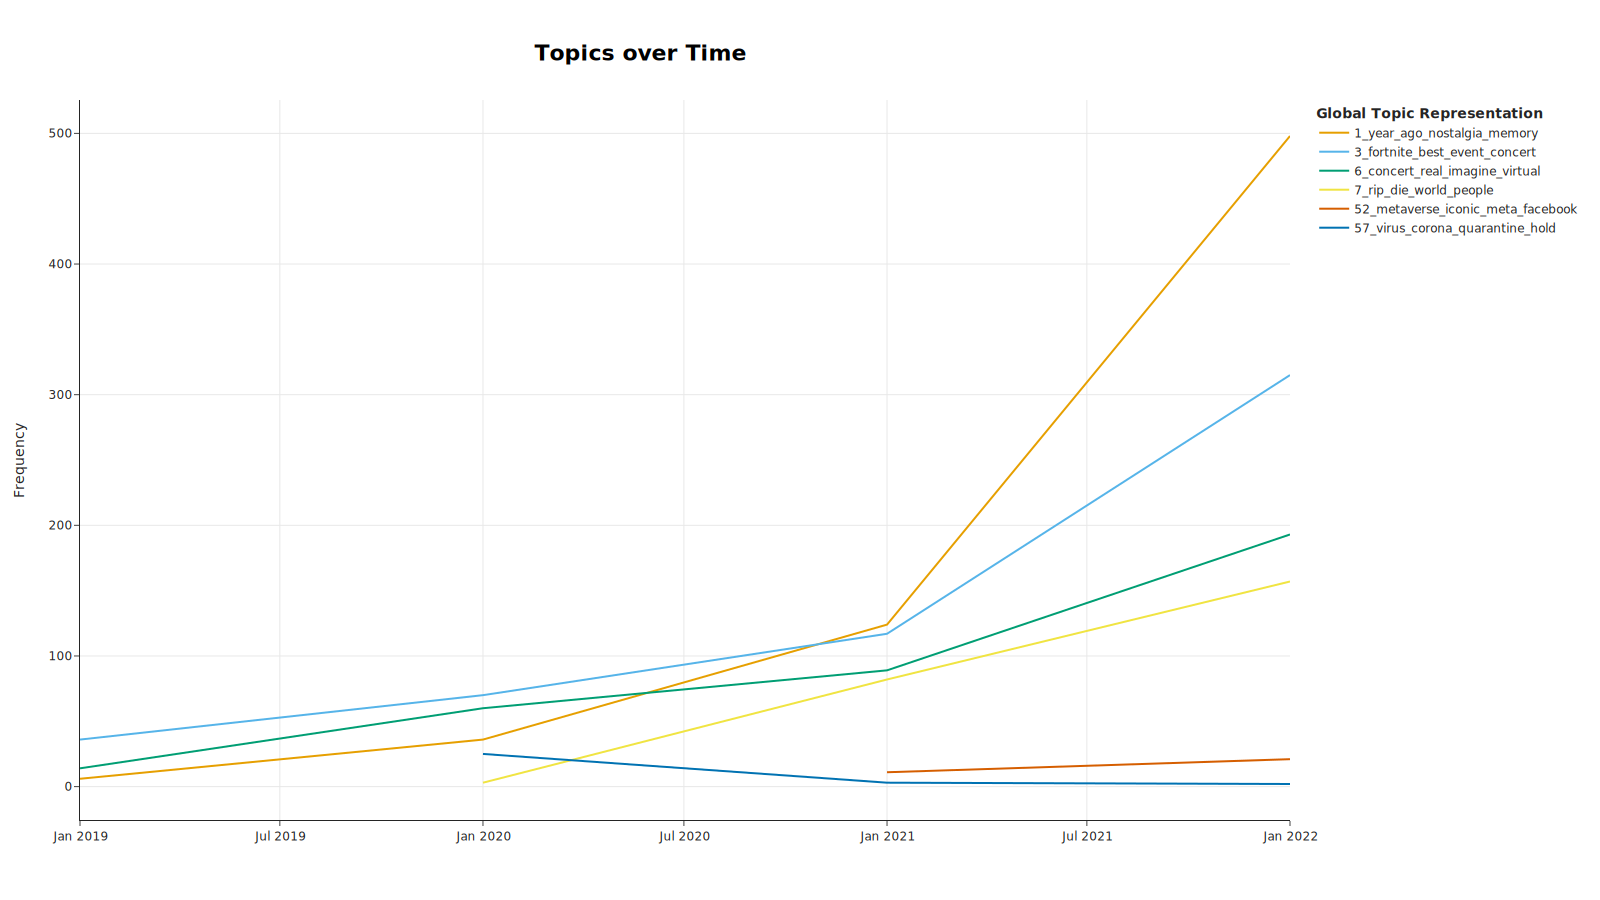

In [995]:
topic_key_model.visualize_topics_over_time(topics_over_time, topics=[3, 1, 6, 7, 52, 57], normalize_frequency = False,
                                          width = 1600, height = 900)

In [949]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[1, 4, 7, 14, 78, 81], normalize_frequency = True,
                                          width = 1200, height = 800)
fig.write_image('visualize_topic_overtime_1.png', engine='kaleido')

In [950]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[1, 4, 7, 14, 81], normalize_frequency = True,
                                          width = 1200, height = 800)
fig.write_image('visualize_topic_overtime_2.png', engine='kaleido')

In [952]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[1, 4, 73, 7, 14, 78, 81], normalize_frequency = True,
                                          width = 1200, height = 800)
fig.write_image('visualize_topic_overtime_3.png', engine='kaleido')

In [975]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[3, 1, 6, 7, 52, 56, 57], normalize_frequency = True,
                                          width = 1200, height = 800)
fig.write_image('visualize_topic_overtime_4.png', engine='kaleido')

In [996]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[3, 1, 6, 7, 52, 56, 57], normalize_frequency = False,
                                          width = 1600, height = 900)
fig.write_image('visualize_topic_overtime_6.png', engine='kaleido')

In [987]:
fig = topic_key_model.visualize_topics_over_time(topics_over_time, topics=[3, 1, 6, 7, 52, 57], normalize_frequency = False,
                                          width = 1200, height = 800)
fig.write_image('visualize_topic_overtime_7.png', engine='kaleido')

## Topic by Class
I used the google colab since I have the problem with utilize plotly library
https://colab.research.google.com/drive/1mfuxVDtCTDeB2T0QImLuEsAw9bZT5OlZ#scrollTo=c60c463f-c8b0-4818-9725-93adf211bd97

In [10]:
# Pre- Embedding
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(df_whole, show_progress_bar=True)

Batches:   0%|          | 0/1141 [00:00<?, ?it/s]

In [11]:
from keybert import KeyBERT

# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(df_whole)

# Create our vocabulary
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

In [12]:
df["class"]

0                         vr_concert
1                         vr_concert
2                         vr_concert
3                         vr_concert
4                         vr_concert
                    ...             
36480    general_concert_after_covid
36481    general_concert_after_covid
36482    general_concert_after_covid
36483    general_concert_after_covid
36484    general_concert_after_covid
Name: class, Length: 36485, dtype: object

In [13]:
docs = df_whole
#targets = data["target"]
#target_names = data["target_names"]
classes = df["class"].to_list()

In [ ]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors = 7, # 8 -> 7
                  n_components = 4, # 5 -> 4
                  metric='cosine')
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size = 30,# 30
                        min_samples = 6, #5*** -> 6
                        metric='euclidean', cluster_selection_method='eom', 
                        gen_min_span_tree=True,
                        prediction_data=True)
# Step 4 - Tokenize topics
#stop_words = stop_words
vectorizer_model = CountVectorizer(vocabulary=vocabulary, stop_words = "english")
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words = False)

In [ ]:
topic_key_model = BERTopic(
    #embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    diversity= 0.55,                      # Step 6 - Diversify topic words
    calculate_probabilities = False,
    top_n_words = 15, #15***
    language = "english",
    n_gram_range = (1, 1),
    min_topic_size = 10, #10 - 15
    nr_topics = "auto"
)
topic_key_model.save("key_model")

In [19]:
topic_key_model = BERTopic.load("key_model")

In [20]:
topics, probs = topic_key_model.fit_transform(df_whole, embeddings)

In [21]:
topics = topic_key_model.get_topic_info()
topics

,Topic,Count,Name
0,-1,10580,-1_ariana_know_concert_like
1,0,1049,0_event_fortnite_best_concert
2,1,926,1_love_song_gesture_pack
3,2,851,2_beautiful_voice_arianas_vocal
4,3,548,3_grand_ariana_love_sings
...,...,...,...
248,247,30,247_white_betty_alien_human
249,248,30,248_terminator_seller_half_activate
250,249,30,249_scar_irma_touch_try
251,250,30,250_gem_origins_ledge_lantern


In [22]:
topics_per_class = topic_key_model.topics_per_class(df_whole, classes=classes)

In [51]:
topic_key_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)

NameError: name 'topic_key_model' is not defined

In [28]:
topics_per_class

,Topic,Words,Frequency,Class
0,-1,"vocal, voice, way, ariana, like",3663,general_concert_after_covid
1,0,"beautiful, voice, performance, arianas, sing",774,general_concert_after_covid
2,1,"best, fortnite, meal, thee, shockwave",39,general_concert_after_covid
3,2,"smiley, happy, weekend, smile, ariana",333,general_concert_after_covid
4,3,"marshmello, marsh, lego, dub, set",271,general_concert_after_covid
...,...,...,...,...
745,252,"cossack, reba, mhz, fold, member",4,vr_concert
746,253,"cd, scrotum, nero, address, simp",10,vr_concert
747,254,"damn, yikes, mil, boy, age",1,vr_concert
748,256,"visuals, visual, sharing, virtual, fortunate",11,vr_concert
